# NeMo SD - oracleVAD voxconverse 9.6%

In [1]:
# """
# You can run either this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.
# TitaNet: https://arxiv.org/pdf/2110.04410.pdf

# Instructions for setting up Colab are as follows:
# https://colab.research.google.com/drive/1ZoALe4Vy4ekR3eedVwyyt1zF8ZjPZ2JU#scrollTo=sDtW2e8u634q
# 1. Open a new Python 3 notebook.
# 2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
# 3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
# 4. Run this cell to set up dependencies.
# """
# # If you're using Google Colab and not running locally, run this cell.

# ## Install dependencies
# !pip install wget
# !apt-get install sox libsndfile1 ffmpeg
# !pip install unidecode

# # ## Install NeMo
# BRANCH = 'main'
# !python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[asr]

# ## Install TorchAudio
# !pip install torchaudio -f https://download.pytorch.org/whl/torch_stable.html
# # !pip install torch==1.11.0 torchaudio==0.11.0 torchvision==0.12.0

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
# CUDA_VISIBLE_DEVICES options = 0/1/2/3. Make sure to restart
!echo $CUDA_VISIBLE_DEVICES

3


In [3]:
import os
import glob
import subprocess
import tarfile
import wget
import pandas as pd
from collections import Counter
from omegaconf import OmegaConf
import numpy as np
import spyder

import IPython
from pyannote.metrics.diarization import DiarizationErrorRate
from nemo.collections.asr.parts.utils.speaker_utils import rttm_to_labels, labels_to_pyannote_object
from nemo.collections.asr.models import ClusteringDiarizer


/root/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
[NeMo W 2022-07-24 16:01:34 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.


In [4]:
ROOT = os.getcwd()
data_dir = os.path.join(ROOT,'data/voxconverse')
os.makedirs(data_dir, exist_ok=True)
print("ROOT: ", ROOT)
print("Data Directory: ", data_dir)
      
audio_filepath = '/home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio'
groundtruth_rttm_filepath = os.path.join(data_dir, 'rttms')
print(groundtruth_rttm_filepath)
# has a train,dev,test subdir

if not os.path.exists(audio_filepath):
    print("Please give correct audio location. No ", audio_filepath)
if not os.path.exists(groundtruth_rttm_filepath):
    print("Please give correct rttm groundtruth location. No ", groundtruth_rttm_filepath)

    
test_type = 'test'
groundtruth_rttm_list = []
if test_type == 'test':
    groundtruth_rttm_list = glob.glob(groundtruth_rttm_filepath + '/test/*.rttm', recursive=True)
    for test_path in groundtruth_rttm_list:
        print(test_path)

!find {audio_filepath} -iname "*.wav" > data/voxconverse/train_all.txt
# !cat {data_dir}/voxconverse/train_all.txt
# DEMO_FILE = {'uri': 'ES2004a.Mix-Headset', 'audio': 'ES2004a.Mix-Headset.wav'}


audio_list = []
with open(data_dir+'/train_all.txt') as data:
    audio_list.append(data.read().split())
audio_list = audio_list[0]
audio_list

ROOT:  /home/DATA/amit_kesari/SD1/NeMo-Nvidia
Data Directory:  /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse
/home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/rttms
/home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/rttms/test/aepyx.rttm
/home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/rttms/test/aggyz.rttm
/home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/rttms/test/aiqwk.rttm
/home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/rttms/test/aorju.rttm
/home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/rttms/test/auzru.rttm
/home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/rttms/test/bgvvt.rttm
/home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/rttms/test/bidnq.rttm
/home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/rttms/test/bjruf.rttm
/home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/rttms/test/bmsyn.rttm
/home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/rttms/test/bpzsc.rttm
/home/DATA/amit_kesari/SD1/NeMo-Nvidia/

['/home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/aepyx.wav',
 '/home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/aggyz.wav',
 '/home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/aiqwk.wav',
 '/home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/aorju.wav',
 '/home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/auzru.wav',
 '/home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/bgvvt.wav',
 '/home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/bidnq.wav',
 '/home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/bjruf.wav',
 '/home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/bmsyn.wav',
 '/home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/bpzsc.wav',
 '/home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/bvqnu.wav',
 '/home/DATA/amit_kesari/downloa

In [5]:
def create_input_manifest(
    audio_filepath,
    rttm_filepath,
    offset=0,
    duration=None,
    label='infer',
    text='-',
    num_speakers=None,
    uem_filepath=None,
    manifest_filepath='/data/input_manifest.json' 
):
    # Create a manifest for input with below format. 
    # {'audio_filepath': /path/to/audio_file, 'offset': 0, 'duration':None, 'label': 'infer', 'text': '-', 
    # 'num_speakers': None, 'rttm_filepath': /path/to/rttm/file, 'uem_filepath'='/path/to/uem/filepath'}
    # if you would like to evaluate with known number of speakers pass the value else None. 
    # If you would like to score the system with known rttms then that should be passed as well, else None
    
    import json
    meta = {
        'audio_filepath': audio_filepath, 
        'offset': 0, 
        'duration':None, 
        'label': 'infer', 
        'text': '-', 
        'num_speakers': num_speakers, 
        'rttm_filepath': rttm_filepath, 
        'uem_filepath' : None
    }
    with open(manifest_filepath,'w') as fp:
        json.dump(meta,fp)
        fp.write('\n')

#     dataframe = pd.DataFrame.from_dict(meta, orient='index')
#     print("Manifest: ", meta)

    
def convert_ami_base():
    """
    Convert audio base name and rttm labels to be same
    # Eg: TS3003a.rttm -> TS3003a.Mix-Headset.rttm
    """
    groundtruth_rttm_list = glob.glob(groundtruth_rttm_filepath + '/test/*.rttm', recursive=True)
    for test_path in groundtruth_rttm_list:
        new_test_path = test_path[:-5]+".Mix-Headset.rttm"
        !mv {test_path} {new_test_path}
        print("new ", new_test_path)

        
        
## RUN ONLY ONCE! Convert rttm to same AMI base name
# convert_ami_base()

In [6]:
# single inialisations
scripts_dir = os.path.join(ROOT, 'scripts/speaker_tasks')
manifest_filepath = os.path.join(data_dir, 'input_manifest.json')
output_dir = os.path.join(data_dir, 'oracle_vad')
os.makedirs(output_dir,exist_ok=True)


MODEL_CONFIG = os.path.join(data_dir,'offline_diarization.yaml')
if not os.path.exists(MODEL_CONFIG):
    config_url = "https://raw.githubusercontent.com/NVIDIA/NeMo/main/examples/speaker_tasks/diarization/conf/offline_diarization.yaml"
    MODEL_CONFIG = wget.download(config_url, data_dir)

config = OmegaConf.load(MODEL_CONFIG)
print(OmegaConf.to_yaml(config))

metric = DiarizationErrorRate()
der2 = 0
vox_labels = []
for single_rttm in groundtruth_rttm_list:
    vox_label = single_rttm.split(sep="/")[-1]
    vox_label = vox_label[:-5] # remove .rttm from last
    vox_labels.append(vox_label)
    labels = rttm_to_labels(single_rttm)
    groundtruth = labels_to_pyannote_object(labels)
    num_speakers = Counter([l.split()[-1] for l in labels]).keys().__len__()

    # find the corresponding audio file according to rttm
    single_audio = [audio for audio in audio_list if vox_label in audio][0]
    
    ## -----Visualise data-----
    print("voxconverse_label: ", vox_label)    
    # !cat {single_rttm} # view the sample groundtruth rttm file
    # print("labels: ",vox_label, groundtruth)
    print("num_speakers: ", num_speakers)   
    # print("single_audio: ", single_audio)

    # -----Create input manifest and configs-----
    create_input_manifest(audio_filepath=single_audio, rttm_filepath=single_rttm, num_speakers=num_speakers, manifest_filepath=manifest_filepath)
    # change configurations:
    pretrained_speaker_model='titanet_large'
    config.diarizer.manifest_filepath = manifest_filepath
    config.diarizer.out_dir = output_dir # Directory to store intermediate files and prediction outputs
    config.diarizer.speaker_embeddings.model_path = pretrained_speaker_model
    config.diarizer.speaker_embeddings.parameters.window_length_in_sec = 1.5
    config.diarizer.speaker_embeddings.parameters.shift_length_in_sec = 0.75
    config.diarizer.speaker_embeddings.parameters.save_embeddings = True
    config.diarizer.ignore_overlap = False
    config.diarizer.oracle_vad = True # ----> ORACLE VAD 
    # no speaker number init so false
    config.diarizer.clustering.parameters.oracle_num_speakers = False
    # print(OmegaConf.to_yaml(config))
    
    # -----Load model and diarize-----
    oracle_model = ClusteringDiarizer(cfg=config)  
    oracle_model.diarize()
    
    # -----Accumulate DER-----
    pred_labels = rttm_to_labels(output_dir+'/pred_rttms/'+vox_label+'.rttm')
    hypothesis = labels_to_pyannote_object(pred_labels)
    der = metric(groundtruth, hypothesis)
    print(f"Diarization error rate (DER) = {100 * der:.1f}%\n\n")


    
    
"""
Diarization error rate (DER) = 8.9%
"""

name: ClusterDiarizer
num_workers: 4
sample_rate: 16000
batch_size: 64
diarizer:
  manifest_filepath: ???
  out_dir: ???
  oracle_vad: false
  collar: 0.25
  ignore_overlap: true
  vad:
    model_path: null
    external_vad_manifest: null
    parameters:
      window_length_in_sec: 0.15
      shift_length_in_sec: 0.01
      smoothing: median
      overlap: 0.875
      onset: 0.4
      offset: 0.7
      pad_onset: 0.05
      pad_offset: -0.1
      min_duration_on: 0.2
      min_duration_off: 0.2
      filter_speech_first: true
  speaker_embeddings:
    model_path: ???
    parameters:
      window_length_in_sec: 1.5
      shift_length_in_sec: 0.75
      multiscale_weights: null
      save_embeddings: false
  clustering:
    parameters:
      oracle_num_speakers: false
      max_num_speakers: 20
      enhanced_count_thres: 80
      max_rp_threshold: 0.25
      sparse_search_volume: 30
      maj_vote_spk_count: false

voxconverse_label:  aepyx
num_speakers:  4
[NeMo I 2022-07-24 16:01:37 c

[NeMo W 2022-07-24 16:01:38 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:01:38 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-24 16:01:38 features:200] PADDING: 16
[NeMo I 2022-07-24 16:01:38 label_models:100] loss is Angular Softmax


[NeMo W 2022-07-24 16:01:38 nemo_logging:349] /root/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                    not been set for this class (TopKClassificationAccuracy). The property determines if `update` by
                    default needs access to the full metric state. If this is not the case, significant speedups can be
                    achieved and we recommend setting this to `False`.
                    We provide an checking function
                    `from torchmetrics.utilities import check_forward_no_full_state`
                    that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                    default for now) or if `full_state_update=False` can be used safely.
                    
      warnings.warn(*args, **kwargs)
    


[NeMo I 2022-07-24 16:01:41 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:01:41 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:01:41 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:01:41 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:01:41 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:01:41 collections:293] # 181 files loaded accounting to # 1 labels


100%|██████████| 3/3 [00:00<00:00,  5.78it/s]

[NeMo I 2022-07-24 16:01:42 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.52s/it]
[NeMo W 2022-07-24 16:01:43 nemo_logging:349] /root/anaconda3/lib/python3.9/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
      warnings.warn(
    


[NeMo I 2022-07-24 16:01:43 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0178	                 Diarization ER: 0.0178	, Confusion ER:0.0000
[NeMo I 2022-07-24 16:01:43 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 2.4%


voxconverse_label:  aggyz
num_speakers:  13
[NeMo I 2022-07-24 16:01:43 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:01:43 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:01:43 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:01:43 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-24 16:01:44 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:01:44 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-24 16:01:44 features:200] PADDING: 16
[NeMo I 2022-07-24 16:01:45 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:01:45 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:01:45 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:01:45 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:01:45 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:01:45 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:01:45 collections:293] # 317 files loaded accounting to # 1 labels


100%|██████████| 5/5 [00:00<00:00,  8.35it/s]

[NeMo I 2022-07-24 16:01:46 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:04<00:00,  4.93s/it]

[NeMo I 2022-07-24 16:01:50 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0066	                 Diarization ER: 0.0651	, Confusion ER:0.0585
[NeMo I 2022-07-24 16:01:50 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 7.5%


voxconverse_label:  aiqwk
num_speakers:  8
[NeMo I 2022-07-24 16:01:51 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:01:51 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:01:51 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:01:51 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:01:51 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:01:51 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:01:51 features:200] PADDING: 16
[NeMo I 2022-07-24 16:01:52 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:01:52 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:01:52 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:01:52 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:01:52 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:01:52 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:01:52 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:01:52 collections:293] # 218 files loaded accounting to # 1 labels


100%|██████████| 4/4 [00:00<00:00,  6.95it/s]

[NeMo I 2022-07-24 16:01:53 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:02<00:00,  2.47s/it]

[NeMo I 2022-07-24 16:01:55 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0047	                 Diarization ER: 0.3118	, Confusion ER:0.3071
[NeMo I 2022-07-24 16:01:55 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 32.4%


voxconverse_label:  aorju
num_speakers:  12
[NeMo I 2022-07-24 16:01:55 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:01:55 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:01:55 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:01:55 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:01:56 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:01:56 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:01:56 features:200] PADDING: 16
[NeMo I 2022-07-24 16:01:57 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:01:57 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:01:57 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:01:57 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:01:57 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:01:57 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:01:57 collections:293] # 1390 files loaded accounting to # 1 labels


100%|██████████| 22/22 [00:01<00:00, 15.69it/s]

[NeMo I 2022-07-24 16:01:58 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:03<00:00,  3.00s/it]

[NeMo I 2022-07-24 16:02:01 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0007	                 Diarization ER: 0.1129	, Confusion ER:0.1122
[NeMo I 2022-07-24 16:02:01 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 12.6%


voxconverse_label:  auzru
num_speakers:  8
[NeMo I 2022-07-24 16:02:01 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:02:01 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:02:01 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:02:01 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:02:02 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:02:02 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:02:02 features:200] PADDING: 16
[NeMo I 2022-07-24 16:02:03 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:02:03 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:02:03 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:02:03 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:02:03 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:02:03 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:02:03 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:02:03 collections:293] # 668 files loaded accounting to # 1 labels


100%|██████████| 11/11 [00:00<00:00, 11.74it/s]


[NeMo I 2022-07-24 16:02:04 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.79s/it]

[NeMo I 2022-07-24 16:02:06 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0008	                 Diarization ER: 0.0182	, Confusion ER:0.0174
[NeMo I 2022-07-24 16:02:06 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 2.9%


voxconverse_label:  bgvvt
num_speakers:  2
[NeMo I 2022-07-24 16:02:06 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:02:06 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:02:06 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:02:06 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:02:07 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:02:07 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:02:07 features:200] PADDING: 16
[NeMo I 2022-07-24 16:02:07 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:02:07 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:02:07 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:02:07 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:02:07 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:02:07 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:02:07 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:02:07 collections:293] # 1267 files loaded accounting to # 1 labels


100%|██████████| 20/20 [00:01<00:00, 14.56it/s]


[NeMo I 2022-07-24 16:02:09 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

[NeMo I 2022-07-24 16:02:10 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0008	                 Diarization ER: 0.0012	, Confusion ER:0.0004
[NeMo I 2022-07-24 16:02:10 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory


Diarization error rate (DER) = 0.5%


voxconverse_label:  bidnq
num_speakers:  11
[NeMo I 2022-07-24 16:02:10 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:02:10 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:02:10 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:02:10 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-24 16:02:11 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:02:11 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-24 16:02:11 features:200] PADDING: 16
[NeMo I 2022-07-24 16:02:12 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:02:12 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:02:12 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:02:12 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:02:12 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:02:12 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:02:12 collections:293] # 1297 files loaded accounting to # 1 labels


100%|██████████| 21/21 [00:01<00:00, 15.35it/s]

[NeMo I 2022-07-24 16:02:13 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


[NeMo I 2022-07-24 16:02:15 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0753	                 Diarization ER: 0.0964	, Confusion ER:0.0212
[NeMo I 2022-07-24 16:02:15 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 16.2%


voxconverse_label:  bjruf
num_speakers:  2
[NeMo I 2022-07-24 16:02:15 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:02:15 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:02:15 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:02:15 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-24 16:02:16 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:02:16 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-24 16:02:16 features:200] PADDING: 16
[NeMo I 2022-07-24 16:02:16 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:02:16 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:02:16 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:02:16 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:02:16 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:02:16 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:02:16 collections:293] # 422 files loaded accounting to # 1 labels


100%|██████████| 7/7 [00:00<00:00,  9.83it/s]

[NeMo I 2022-07-24 16:02:17 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.62s/it]

[NeMo I 2022-07-24 16:02:19 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0689	                 Diarization ER: 0.0744	, Confusion ER:0.0055
[NeMo I 2022-07-24 16:02:19 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 13.6%


voxconverse_label:  bmsyn
num_speakers:  5
[NeMo I 2022-07-24 16:02:19 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:02:19 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:02:19 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:02:19 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:02:20 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:02:20 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:02:20 features:200] PADDING: 16
[NeMo I 2022-07-24 16:02:20 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:02:20 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:02:20 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:02:20 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:02:20 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:02:20 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:02:20 collections:293] # 672 files loaded accounting to # 1 labels


100%|██████████| 11/11 [00:00<00:00, 11.94it/s]


[NeMo I 2022-07-24 16:02:21 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


[NeMo I 2022-07-24 16:02:23 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0367	                 Diarization ER: 0.0833	, Confusion ER:0.0466
[NeMo I 2022-07-24 16:02:23 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 16.3%


voxconverse_label:  bpzsc
num_speakers:  7
[NeMo I 2022-07-24 16:02:23 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:02:23 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:02:23 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:02:23 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-24 16:02:24 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:02:24 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-24 16:02:24 features:200] PADDING: 16
[NeMo I 2022-07-24 16:02:24 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:02:25 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:02:25 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:02:25 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:02:25 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:02:25 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:02:25 collections:293] # 1306 files loaded accounting to # 1 labels


100%|██████████| 21/21 [00:01<00:00, 15.97it/s]


[NeMo I 2022-07-24 16:02:26 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

[NeMo I 2022-07-24 16:02:28 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0165	                 Diarization ER: 0.0231	, Confusion ER:0.0066
[NeMo I 2022-07-24 16:02:28 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 5.4%


voxconverse_label:  bvqnu
num_speakers:  9
[NeMo I 2022-07-24 16:02:28 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:02:28 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:02:28 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:02:28 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:02:29 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:02:29 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:02:29 features:200] PADDING: 16
[NeMo I 2022-07-24 16:02:29 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:02:29 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:02:29 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:02:29 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:02:29 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:02:29 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:02:29 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:02:29 collections:293] # 689 files loaded accounting to # 1 labels


100%|██████████| 11/11 [00:00<00:00, 11.76it/s]


[NeMo I 2022-07-24 16:02:30 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

[NeMo I 2022-07-24 16:02:32 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0148	                 Diarization ER: 0.1934	, Confusion ER:0.1786
[NeMo I 2022-07-24 16:02:32 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 23.0%


voxconverse_label:  bvyvm
num_speakers:  3
[NeMo I 2022-07-24 16:02:32 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:02:32 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:02:32 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:02:32 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:02:33 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:02:33 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:02:33 features:200] PADDING: 16
[NeMo I 2022-07-24 16:02:33 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:02:33 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:02:33 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:02:33 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:02:33 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:02:33 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:02:33 collections:293] # 134 files loaded accounting to # 1 labels


100%|██████████| 3/3 [00:00<00:00,  5.56it/s]

[NeMo I 2022-07-24 16:02:34 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

[NeMo I 2022-07-24 16:02:35 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.0000	, Confusion ER:0.0000
[NeMo I 2022-07-24 16:02:35 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 0.0%


voxconverse_label:  bxcfq
num_speakers:  2
[NeMo I 2022-07-24 16:02:35 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:02:35 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:02:35 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:02:35 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:02:35 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:02:35 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:02:35 features:200] PADDING: 16
[NeMo I 2022-07-24 16:02:36 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:02:36 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:02:36 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:02:36 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:02:36 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:02:36 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:02:36 collections:293] # 261 files loaded accounting to # 1 labels


100%|██████████| 5/5 [00:00<00:00,  8.43it/s]

[NeMo I 2022-07-24 16:02:37 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

[NeMo I 2022-07-24 16:02:38 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0070	                 Diarization ER: 0.0084	, Confusion ER:0.0014
[NeMo I 2022-07-24 16:02:38 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 3.1%


voxconverse_label:  byapz
num_speakers:  15
[NeMo I 2022-07-24 16:02:38 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:02:38 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:02:38 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:02:38 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:02:38 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:02:38 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:02:38 features:200] PADDING: 16
[NeMo I 2022-07-24 16:02:39 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:02:39 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:02:39 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:02:39 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:02:39 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:02:39 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:02:39 collections:293] # 531 files loaded accounting to # 1 labels


100%|██████████| 9/9 [00:00<00:00, 11.63it/s]

[NeMo I 2022-07-24 16:02:40 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:02<00:00,  2.52s/it]

[NeMo I 2022-07-24 16:02:42 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.0769	, Confusion ER:0.0769
[NeMo I 2022-07-24 16:02:42 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 8.5%


voxconverse_label:  cadba
num_speakers:  7
[NeMo I 2022-07-24 16:02:42 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:02:42 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:02:42 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:02:42 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:02:43 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:02:43 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:02:43 features:200] PADDING: 16
[NeMo I 2022-07-24 16:02:44 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:02:44 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:02:44 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:02:44 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:02:44 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:02:44 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:02:44 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:02:44 collections:293] # 221 files loaded accounting to # 1 labels


100%|██████████| 4/4 [00:00<00:00,  7.28it/s]

[NeMo I 2022-07-24 16:02:44 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

[NeMo I 2022-07-24 16:02:46 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0272	                 Diarization ER: 0.2227	, Confusion ER:0.1956
[NeMo I 2022-07-24 16:02:46 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 22.7%


voxconverse_label:  cawnd
num_speakers:  9
[NeMo I 2022-07-24 16:02:46 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:02:46 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:02:46 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:02:46 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:02:46 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:02:46 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:02:46 features:200] PADDING: 16
[NeMo I 2022-07-24 16:02:47 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:02:47 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:02:47 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:02:47 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:02:47 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:02:47 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:02:47 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:02:47 collections:293] # 1490 files loaded accounting to # 1 labels


100%|██████████| 24/24 [00:01<00:00, 15.30it/s]


[NeMo I 2022-07-24 16:02:49 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.64s/it]

[NeMo I 2022-07-24 16:02:50 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0015	                 Diarization ER: 0.3259	, Confusion ER:0.3244
[NeMo I 2022-07-24 16:02:50 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 32.6%


voxconverse_label:  clfcg
num_speakers:  9
[NeMo I 2022-07-24 16:02:51 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:02:51 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:02:51 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:02:51 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:02:51 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:02:51 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:02:51 features:200] PADDING: 16
[NeMo I 2022-07-24 16:02:52 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:02:52 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:02:52 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:02:52 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:02:52 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:02:52 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:02:52 collections:293] # 344 files loaded accounting to # 1 labels


100%|██████████| 6/6 [00:00<00:00,  9.22it/s]

[NeMo I 2022-07-24 16:02:53 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.25s/it]

[NeMo I 2022-07-24 16:02:54 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.0845	, Confusion ER:0.0845
[NeMo I 2022-07-24 16:02:54 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 8.3%


voxconverse_label:  cpebh
num_speakers:  1
[NeMo I 2022-07-24 16:02:54 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:02:54 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:02:54 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:02:54 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:02:55 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:02:55 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:02:55 features:200] PADDING: 16
[NeMo I 2022-07-24 16:02:56 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:02:56 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:02:56 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:02:56 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:02:56 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:02:56 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:02:56 collections:293] # 857 files loaded accounting to # 1 labels


100%|██████████| 14/14 [00:01<00:00, 13.90it/s]

[NeMo I 2022-07-24 16:02:57 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.73s/it]

[NeMo I 2022-07-24 16:02:58 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.0000	, Confusion ER:0.0000
[NeMo I 2022-07-24 16:02:58 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 0.0%


voxconverse_label:  cqfmj
num_speakers:  4
[NeMo I 2022-07-24 16:02:58 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:02:58 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:02:58 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:02:58 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:02:59 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:02:59 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:02:59 features:200] PADDING: 16
[NeMo I 2022-07-24 16:03:00 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:03:00 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:03:00 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:03:00 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:03:00 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:03:00 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:03:00 collections:293] # 132 files loaded accounting to # 1 labels


100%|██████████| 3/3 [00:00<00:00,  5.96it/s]

[NeMo I 2022-07-24 16:03:00 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

[NeMo I 2022-07-24 16:03:01 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0363	                 Diarization ER: 0.0445	, Confusion ER:0.0082
[NeMo I 2022-07-24 16:03:01 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 6.8%


voxconverse_label:  crorm
num_speakers:  2
[NeMo I 2022-07-24 16:03:01 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:03:01 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:03:01 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:03:01 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:03:02 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:03:02 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:03:02 features:200] PADDING: 16
[NeMo I 2022-07-24 16:03:02 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:03:02 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:03:02 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:03:02 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:03:02 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:03:02 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:03:02 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:03:02 collections:293] # 1136 files loaded accounting to # 1 labels


100%|██████████| 18/18 [00:01<00:00, 14.36it/s]

[NeMo I 2022-07-24 16:03:04 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.56s/it]

[NeMo I 2022-07-24 16:03:05 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0011	                 Diarization ER: 0.0098	, Confusion ER:0.0086
[NeMo I 2022-07-24 16:03:05 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 1.2%


voxconverse_label:  crylr
num_speakers:  4
[NeMo I 2022-07-24 16:03:05 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:03:05 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:03:05 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:03:05 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:03:06 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:03:06 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:03:06 features:200] PADDING: 16
[NeMo I 2022-07-24 16:03:07 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:03:07 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:03:07 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:03:07 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:03:07 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:03:07 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:03:07 collections:293] # 194 files loaded accounting to # 1 labels


100%|██████████| 4/4 [00:00<00:00,  7.16it/s]

[NeMo I 2022-07-24 16:03:07 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

[NeMo I 2022-07-24 16:03:08 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0061	                 Diarization ER: 0.2249	, Confusion ER:0.2188
[NeMo I 2022-07-24 16:03:08 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 22.6%


voxconverse_label:  cvofp
num_speakers:  6
[NeMo I 2022-07-24 16:03:08 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:03:08 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:03:08 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:03:08 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:03:09 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:03:09 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:03:09 features:200] PADDING: 16
[NeMo I 2022-07-24 16:03:09 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:03:10 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:03:10 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:03:10 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:03:10 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:03:10 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:03:10 collections:293] # 1420 files loaded accounting to # 1 labels


100%|██████████| 23/23 [00:01<00:00, 16.04it/s]

[NeMo I 2022-07-24 16:03:11 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.72s/it]

[NeMo I 2022-07-24 16:03:13 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0022	                 Diarization ER: 0.0034	, Confusion ER:0.0012
[NeMo I 2022-07-24 16:03:13 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 0.8%


voxconverse_label:  cwbvu
num_speakers:  10
[NeMo I 2022-07-24 16:03:13 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:03:13 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:03:13 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:03:13 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:03:14 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:03:14 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:03:14 features:200] PADDING: 16
[NeMo I 2022-07-24 16:03:14 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:03:14 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:03:14 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:03:14 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:03:14 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:03:14 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:03:14 collections:293] # 150 files loaded accounting to # 1 labels


100%|██████████| 3/3 [00:00<00:00,  5.70it/s]

[NeMo I 2022-07-24 16:03:15 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

[NeMo I 2022-07-24 16:03:16 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.1668	                 Diarization ER: 0.2188	, Confusion ER:0.0520
[NeMo I 2022-07-24 16:03:16 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 25.1%


voxconverse_label:  dgvwu
num_speakers:  11
[NeMo I 2022-07-24 16:03:16 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:03:16 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:03:16 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:03:16 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:03:17 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:03:17 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:03:17 features:200] PADDING: 16
[NeMo I 2022-07-24 16:03:17 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:03:17 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:03:17 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:03:17 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:03:17 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:03:17 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:03:17 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:03:17 collections:293] # 964 files loaded accounting to # 1 labels


100%|██████████| 16/16 [00:01<00:00, 14.23it/s]

[NeMo I 2022-07-24 16:03:18 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.54s/it]

[NeMo I 2022-07-24 16:03:20 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0202	                 Diarization ER: 0.0857	, Confusion ER:0.0655
[NeMo I 2022-07-24 16:03:20 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 11.6%


voxconverse_label:  diysk
num_speakers:  15
[NeMo I 2022-07-24 16:03:20 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:03:20 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:03:20 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:03:20 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:03:21 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:03:21 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:03:21 features:200] PADDING: 16
[NeMo I 2022-07-24 16:03:21 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:03:22 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:03:22 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:03:22 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:03:22 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:03:22 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:03:22 collections:293] # 1285 files loaded accounting to # 1 labels


100%|██████████| 21/21 [00:01<00:00, 15.74it/s]

[NeMo I 2022-07-24 16:03:23 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


[NeMo I 2022-07-24 16:03:25 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0426	                 Diarization ER: 0.0879	, Confusion ER:0.0453
[NeMo I 2022-07-24 16:03:25 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 16.3%


voxconverse_label:  dkabn
num_speakers:  7
[NeMo I 2022-07-24 16:03:25 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:03:25 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:03:25 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:03:25 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-24 16:03:26 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:03:26 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-24 16:03:26 features:200] PADDING: 16
[NeMo I 2022-07-24 16:03:27 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:03:27 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:03:27 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:03:27 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:03:27 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:03:27 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:03:27 collections:293] # 1364 files loaded accounting to # 1 labels


100%|██████████| 22/22 [00:01<00:00, 15.56it/s]

[NeMo I 2022-07-24 16:03:28 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.72s/it]

[NeMo I 2022-07-24 16:03:30 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0115	                 Diarization ER: 0.0204	, Confusion ER:0.0089
[NeMo I 2022-07-24 16:03:30 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory


Diarization error rate (DER) = 4.5%


voxconverse_label:  dlast
num_speakers:  9
[NeMo I 2022-07-24 16:03:30 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:03:30 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:03:30 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:03:30 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-24 16:03:31 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:03:31 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-24 16:03:31 features:200] PADDING: 16
[NeMo I 2022-07-24 16:03:32 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:03:32 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:03:32 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:03:32 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:03:32 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:03:32 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:03:32 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:03:32 collections:293] # 1453 files loaded accounting to # 1 labels


100%|██████████| 23/23 [00:01<00:00, 15.65it/s]

[NeMo I 2022-07-24 16:03:33 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:02<00:00,  2.24s/it]

[NeMo I 2022-07-24 16:03:36 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0142	                 Diarization ER: 0.0346	, Confusion ER:0.0204
[NeMo I 2022-07-24 16:03:36 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 4.2%


voxconverse_label:  dohag
num_speakers:  1
[NeMo I 2022-07-24 16:03:36 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:03:36 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:03:36 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:03:36 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:03:36 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:03:36 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:03:36 features:200] PADDING: 16
[NeMo I 2022-07-24 16:03:37 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:03:37 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:03:37 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:03:37 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:03:37 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:03:37 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:03:37 collections:293] # 52 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

[NeMo I 2022-07-24 16:03:37 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.81s/it]

[NeMo I 2022-07-24 16:03:39 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.0000	, Confusion ER:0.0000
[NeMo I 2022-07-24 16:03:39 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 0.0%


voxconverse_label:  duvox
num_speakers:  6
[NeMo I 2022-07-24 16:03:39 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:03:39 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:03:39 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:03:39 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:03:40 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:03:40 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:03:40 features:200] PADDING: 16
[NeMo I 2022-07-24 16:03:41 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:03:41 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:03:41 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:03:41 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:03:41 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:03:41 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:03:41 collections:293] # 1161 files loaded accounting to # 1 labels


100%|██████████| 19/19 [00:01<00:00, 15.22it/s]


[NeMo I 2022-07-24 16:03:42 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.83s/it]

[NeMo I 2022-07-24 16:03:44 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0027	                 Diarization ER: 0.0111	, Confusion ER:0.0084
[NeMo I 2022-07-24 16:03:44 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 2.6%


voxconverse_label:  dxbbt
num_speakers:  3
[NeMo I 2022-07-24 16:03:44 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:03:44 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:03:44 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:03:44 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:03:45 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:03:45 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:03:45 features:200] PADDING: 16
[NeMo I 2022-07-24 16:03:46 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:03:46 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:03:46 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:03:46 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:03:46 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:03:46 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:03:46 collections:293] # 843 files loaded accounting to # 1 labels


100%|██████████| 14/14 [00:01<00:00, 13.59it/s]

[NeMo I 2022-07-24 16:03:47 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.66s/it]

[NeMo I 2022-07-24 16:03:49 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0062	                 Diarization ER: 0.1235	, Confusion ER:0.1173
[NeMo I 2022-07-24 16:03:49 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 13.7%


voxconverse_label:  dxokr
num_speakers:  4
[NeMo I 2022-07-24 16:03:49 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:03:49 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:03:49 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:03:49 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:03:49 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:03:49 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:03:49 features:200] PADDING: 16
[NeMo I 2022-07-24 16:03:50 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:03:50 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:03:50 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:03:50 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:03:50 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:03:50 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:03:50 collections:293] # 228 files loaded accounting to # 1 labels


100%|██████████| 4/4 [00:00<00:00,  6.76it/s]

[NeMo I 2022-07-24 16:03:51 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

[NeMo I 2022-07-24 16:03:51 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.0333	, Confusion ER:0.0333
[NeMo I 2022-07-24 16:03:51 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 3.8%


voxconverse_label:  dzsef
num_speakers:  3
[NeMo I 2022-07-24 16:03:52 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:03:52 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:03:52 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:03:52 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:03:52 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:03:52 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:03:52 features:200] PADDING: 16
[NeMo I 2022-07-24 16:03:53 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:03:53 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:03:53 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:03:53 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:03:53 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:03:53 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:03:53 collections:293] # 214 files loaded accounting to # 1 labels


100%|██████████| 4/4 [00:00<00:00,  7.16it/s]


[NeMo I 2022-07-24 16:03:54 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

[NeMo I 2022-07-24 16:03:55 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.0000	, Confusion ER:0.0000
[NeMo I 2022-07-24 16:03:55 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 0.0%


voxconverse_label:  dzxut
num_speakers:  8
[NeMo I 2022-07-24 16:03:55 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:03:55 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:03:55 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:03:55 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:03:55 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:03:55 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:03:55 features:200] PADDING: 16
[NeMo I 2022-07-24 16:03:56 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:03:56 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:03:56 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:03:56 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:03:56 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:03:56 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:03:56 collections:293] # 201 files loaded accounting to # 1 labels


100%|██████████| 4/4 [00:00<00:00,  7.19it/s]

[NeMo I 2022-07-24 16:03:57 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

[NeMo I 2022-07-24 16:03:57 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0174	                 Diarization ER: 0.2448	, Confusion ER:0.2274
[NeMo I 2022-07-24 16:03:57 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 27.8%


voxconverse_label:  eauve
num_speakers:  7
[NeMo I 2022-07-24 16:03:57 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:03:57 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:03:57 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:03:57 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:03:58 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:03:58 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:03:58 features:200] PADDING: 16
[NeMo I 2022-07-24 16:03:59 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:03:59 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:03:59 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:03:59 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:03:59 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:03:59 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:03:59 collections:293] # 1467 files loaded accounting to # 1 labels


100%|██████████| 23/23 [00:01<00:00, 15.30it/s]


[NeMo I 2022-07-24 16:04:00 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


[NeMo I 2022-07-24 16:04:02 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0626	                 Diarization ER: 0.0728	, Confusion ER:0.0102
[NeMo I 2022-07-24 16:04:02 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 13.3%


voxconverse_label:  eazeq
num_speakers:  2
[NeMo I 2022-07-24 16:04:03 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:04:03 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:04:03 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:04:03 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-24 16:04:03 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:04:03 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-24 16:04:03 features:200] PADDING: 16
[NeMo I 2022-07-24 16:04:04 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:04:04 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:04:04 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:04:04 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:04:04 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:04:04 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:04:04 collections:293] # 120 files loaded accounting to # 1 labels


100%|██████████| 2/2 [00:00<00:00,  4.12it/s]

[NeMo I 2022-07-24 16:04:04 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

[NeMo I 2022-07-24 16:04:05 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0334	                 Diarization ER: 0.4012	, Confusion ER:0.3678
[NeMo I 2022-07-24 16:04:05 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 44.5%


voxconverse_label:  eddje
num_speakers:  4
[NeMo I 2022-07-24 16:04:05 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:04:05 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:04:05 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:04:05 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:04:06 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:04:06 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:04:06 features:200] PADDING: 16
[NeMo I 2022-07-24 16:04:06 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:04:06 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:04:06 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:04:06 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:04:06 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:04:06 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:04:06 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:04:06 collections:293] # 548 files loaded accounting to # 1 labels


100%|██████████| 9/9 [00:00<00:00, 10.96it/s]

[NeMo I 2022-07-24 16:04:07 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:02<00:00,  2.28s/it]

[NeMo I 2022-07-24 16:04:10 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.1000	                 Diarization ER: 0.1017	, Confusion ER:0.0017
[NeMo I 2022-07-24 16:04:10 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 14.8%


voxconverse_label:  eguui
num_speakers:  3
[NeMo I 2022-07-24 16:04:10 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:04:10 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:04:10 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:04:10 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:04:11 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:04:11 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:04:11 features:200] PADDING: 16
[NeMo I 2022-07-24 16:04:11 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:04:11 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:04:11 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:04:11 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:04:11 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:04:11 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:04:11 collections:293] # 129 files loaded accounting to # 1 labels


100%|██████████| 3/3 [00:00<00:00,  6.17it/s]

[NeMo I 2022-07-24 16:04:12 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

[NeMo I 2022-07-24 16:04:12 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.1937	                 Diarization ER: 0.1937	, Confusion ER:0.0000
[NeMo I 2022-07-24 16:04:12 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 22.6%


voxconverse_label:  eoyaz
num_speakers:  8
[NeMo I 2022-07-24 16:04:12 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:04:12 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:04:12 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:04:12 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:04:13 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:04:13 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:04:13 features:200] PADDING: 16
[NeMo I 2022-07-24 16:04:13 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:04:14 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:04:14 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:04:14 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:04:14 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:04:14 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:04:14 collections:293] # 264 files loaded accounting to # 1 labels


100%|██████████| 5/5 [00:00<00:00,  7.67it/s]

[NeMo I 2022-07-24 16:04:14 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

[NeMo I 2022-07-24 16:04:15 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0151	                 Diarization ER: 0.1175	, Confusion ER:0.1024
[NeMo I 2022-07-24 16:04:15 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 15.1%


voxconverse_label:  epygx
num_speakers:  8
[NeMo I 2022-07-24 16:04:15 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:04:15 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:04:15 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:04:15 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:04:16 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:04:16 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:04:16 features:200] PADDING: 16
[NeMo I 2022-07-24 16:04:17 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:04:17 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:04:17 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:04:17 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:04:17 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:04:17 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:04:17 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:04:17 collections:293] # 1295 files loaded accounting to # 1 labels


100%|██████████| 21/21 [00:01<00:00, 15.36it/s]

[NeMo I 2022-07-24 16:04:18 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


[NeMo I 2022-07-24 16:04:20 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0013	                 Diarization ER: 0.0162	, Confusion ER:0.0149
[NeMo I 2022-07-24 16:04:20 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 2.8%


voxconverse_label:  eqsta
num_speakers:  15
[NeMo I 2022-07-24 16:04:20 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:04:20 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:04:20 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:04:20 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-24 16:04:21 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:04:21 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-24 16:04:21 features:200] PADDING: 16
[NeMo I 2022-07-24 16:04:21 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:04:22 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:04:22 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:04:22 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:04:22 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:04:22 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:04:22 collections:293] # 1074 files loaded accounting to # 1 labels


100%|██████████| 17/17 [00:01<00:00, 13.75it/s]

[NeMo I 2022-07-24 16:04:23 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


[NeMo I 2022-07-24 16:04:25 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0670	                 Diarization ER: 0.1618	, Confusion ER:0.0949
[NeMo I 2022-07-24 16:04:25 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 23.8%


voxconverse_label:  erslt
num_speakers:  7
[NeMo I 2022-07-24 16:04:25 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:04:25 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:04:25 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:04:25 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-24 16:04:26 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:04:26 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-24 16:04:26 features:200] PADDING: 16
[NeMo I 2022-07-24 16:04:26 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:04:26 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:04:26 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:04:26 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:04:26 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:04:26 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:04:26 collections:293] # 131 files loaded accounting to # 1 labels


100%|██████████| 3/3 [00:00<00:00,  5.52it/s]

[NeMo I 2022-07-24 16:04:27 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

[NeMo I 2022-07-24 16:04:28 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0358	                 Diarization ER: 0.1295	, Confusion ER:0.0937
[NeMo I 2022-07-24 16:04:28 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 17.1%


voxconverse_label:  eucfa
num_speakers:  4
[NeMo I 2022-07-24 16:04:28 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:04:28 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:04:28 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:04:28 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:04:29 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:04:29 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:04:29 features:200] PADDING: 16
[NeMo I 2022-07-24 16:04:29 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:04:29 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:04:29 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:04:29 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:04:29 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:04:29 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:04:29 collections:293] # 99 files loaded accounting to # 1 labels


100%|██████████| 2/2 [00:00<00:00,  4.05it/s]

[NeMo I 2022-07-24 16:04:30 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:00<00:00,  3.57it/s]

[NeMo I 2022-07-24 16:04:30 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.1380	, Confusion ER:0.1380
[NeMo I 2022-07-24 16:04:30 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 18.3%


voxconverse_label:  euqef
num_speakers:  1
[NeMo I 2022-07-24 16:04:30 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:04:30 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:04:30 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:04:30 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:04:31 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:04:31 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:04:31 features:200] PADDING: 16
[NeMo I 2022-07-24 16:04:31 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:04:31 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:04:31 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:04:31 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:04:31 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:04:31 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:04:31 collections:293] # 32 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

[NeMo I 2022-07-24 16:04:32 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

[NeMo I 2022-07-24 16:04:32 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.0000	, Confusion ER:0.0000
[NeMo I 2022-07-24 16:04:32 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 0.0%


voxconverse_label:  ezxso
num_speakers:  10
[NeMo I 2022-07-24 16:04:32 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:04:32 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:04:32 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:04:32 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:04:33 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:04:33 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:04:33 features:200] PADDING: 16
[NeMo I 2022-07-24 16:04:34 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:04:34 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:04:34 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:04:34 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:04:34 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:04:34 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:04:34 collections:293] # 333 files loaded accounting to # 1 labels


100%|██████████| 6/6 [00:00<00:00,  9.09it/s]

[NeMo I 2022-07-24 16:04:34 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

[NeMo I 2022-07-24 16:04:36 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0007	                 Diarization ER: 0.1737	, Confusion ER:0.1729
[NeMo I 2022-07-24 16:04:36 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 18.0%


voxconverse_label:  fijfi
num_speakers:  6
[NeMo I 2022-07-24 16:04:36 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:04:36 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:04:36 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:04:36 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:04:37 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:04:37 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:04:37 features:200] PADDING: 16
[NeMo I 2022-07-24 16:04:37 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:04:37 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:04:37 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:04:37 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:04:37 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:04:37 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:04:37 collections:293] # 1025 files loaded accounting to # 1 labels


100%|██████████| 17/17 [00:01<00:00, 15.02it/s]

[NeMo I 2022-07-24 16:04:39 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.63s/it]

[NeMo I 2022-07-24 16:04:40 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0081	                 Diarization ER: 0.0216	, Confusion ER:0.0134
[NeMo I 2022-07-24 16:04:40 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 4.1%


voxconverse_label:  fowhl
num_speakers:  6
[NeMo I 2022-07-24 16:04:40 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:04:40 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:04:40 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:04:40 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:04:41 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:04:41 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:04:41 features:200] PADDING: 16
[NeMo I 2022-07-24 16:04:42 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:04:42 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:04:42 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:04:42 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:04:42 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:04:42 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:04:42 collections:293] # 1026 files loaded accounting to # 1 labels


100%|██████████| 17/17 [00:01<00:00, 14.65it/s]

[NeMo I 2022-07-24 16:04:43 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.61s/it]

[NeMo I 2022-07-24 16:04:45 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0150	                 Diarization ER: 0.0479	, Confusion ER:0.0328
[NeMo I 2022-07-24 16:04:45 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 7.7%


voxconverse_label:  fpfvy
num_speakers:  11
[NeMo I 2022-07-24 16:04:45 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:04:45 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:04:45 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:04:45 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:04:46 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:04:46 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:04:46 features:200] PADDING: 16
[NeMo I 2022-07-24 16:04:46 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:04:46 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:04:46 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:04:46 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:04:46 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:04:46 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:04:46 collections:293] # 141 files loaded accounting to # 1 labels


100%|██████████| 3/3 [00:00<00:00,  5.81it/s]

[NeMo I 2022-07-24 16:04:47 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

[NeMo I 2022-07-24 16:04:48 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0030	                 Diarization ER: 0.1898	, Confusion ER:0.1868
[NeMo I 2022-07-24 16:04:48 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 21.8%


voxconverse_label:  fqrnu
num_speakers:  4
[NeMo I 2022-07-24 16:04:48 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:04:48 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:04:48 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:04:48 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:04:48 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:04:48 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:04:48 features:200] PADDING: 16
[NeMo I 2022-07-24 16:04:49 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:04:49 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:04:49 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:04:49 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:04:49 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:04:49 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:04:49 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:04:49 collections:293] # 207 files loaded accounting to # 1 labels


100%|██████████| 4/4 [00:00<00:00,  7.23it/s]


[NeMo I 2022-07-24 16:04:50 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

[NeMo I 2022-07-24 16:04:50 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0433	                 Diarization ER: 0.0728	, Confusion ER:0.0295
[NeMo I 2022-07-24 16:04:50 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 8.7%


voxconverse_label:  fuzfh
num_speakers:  3
[NeMo I 2022-07-24 16:04:50 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:04:50 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:04:50 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:04:50 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:04:51 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:04:51 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:04:51 features:200] PADDING: 16
[NeMo I 2022-07-24 16:04:52 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:04:52 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:04:52 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:04:52 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:04:52 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:04:52 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:04:52 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:04:52 collections:293] # 31 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:00<00:00,  2.50it/s]

[NeMo I 2022-07-24 16:04:52 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

[NeMo I 2022-07-24 16:04:53 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.0429	, Confusion ER:0.0429
[NeMo I 2022-07-24 16:04:53 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 8.8%


voxconverse_label:  fvhrk
num_speakers:  4
[NeMo I 2022-07-24 16:04:53 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:04:53 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:04:53 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:04:53 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:04:53 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:04:53 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:04:53 features:200] PADDING: 16
[NeMo I 2022-07-24 16:04:54 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:04:54 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:04:54 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:04:54 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:04:54 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:04:54 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:04:54 collections:293] # 1454 files loaded accounting to # 1 labels


100%|██████████| 23/23 [00:01<00:00, 15.79it/s]

[NeMo I 2022-07-24 16:04:56 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.67s/it]

[NeMo I 2022-07-24 16:04:57 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.0167	, Confusion ER:0.0167
[NeMo I 2022-07-24 16:04:57 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 1.6%


voxconverse_label:  fxnwf
num_speakers:  3
[NeMo I 2022-07-24 16:04:57 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:04:57 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:04:57 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:04:57 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:04:58 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:04:58 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:04:58 features:200] PADDING: 16
[NeMo I 2022-07-24 16:04:59 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:04:59 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:04:59 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:04:59 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:04:59 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:04:59 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:04:59 collections:293] # 393 files loaded accounting to # 1 labels


100%|██████████| 7/7 [00:00<00:00, 10.00it/s]


[NeMo I 2022-07-24 16:05:00 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.54s/it]

[NeMo I 2022-07-24 16:05:01 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0354	                 Diarization ER: 0.0774	, Confusion ER:0.0420
[NeMo I 2022-07-24 16:05:01 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 12.2%


voxconverse_label:  fyqoe
num_speakers:  3
[NeMo I 2022-07-24 16:05:01 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:05:01 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:05:01 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:05:01 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:05:02 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:05:02 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:05:02 features:200] PADDING: 16
[NeMo I 2022-07-24 16:05:03 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:05:03 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:05:03 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:05:03 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:05:03 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:05:03 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:05:03 collections:293] # 377 files loaded accounting to # 1 labels


100%|██████████| 6/6 [00:00<00:00,  8.61it/s]

[NeMo I 2022-07-24 16:05:04 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

[NeMo I 2022-07-24 16:05:05 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.1114	                 Diarization ER: 0.1346	, Confusion ER:0.0232
[NeMo I 2022-07-24 16:05:05 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 23.2%


voxconverse_label:  fzwtp
num_speakers:  11
[NeMo I 2022-07-24 16:05:05 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:05:05 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:05:05 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:05:05 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:05:06 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:05:06 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:05:06 features:200] PADDING: 16
[NeMo I 2022-07-24 16:05:07 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:05:07 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:05:07 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:05:07 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:05:07 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:05:07 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:05:07 collections:293] # 264 files loaded accounting to # 1 labels


100%|██████████| 5/5 [00:00<00:00,  7.97it/s]

[NeMo I 2022-07-24 16:05:07 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

[NeMo I 2022-07-24 16:05:08 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.1055	, Confusion ER:0.1055
[NeMo I 2022-07-24 16:05:08 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 12.1%


voxconverse_label:  gcfwp
num_speakers:  8
[NeMo I 2022-07-24 16:05:08 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:05:08 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:05:08 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:05:08 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:05:09 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:05:09 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:05:09 features:200] PADDING: 16
[NeMo I 2022-07-24 16:05:10 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:05:10 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:05:10 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:05:10 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:05:10 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:05:10 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:05:10 collections:293] # 312 files loaded accounting to # 1 labels


100%|██████████| 5/5 [00:00<00:00,  7.77it/s]

[NeMo I 2022-07-24 16:05:10 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

[NeMo I 2022-07-24 16:05:12 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.1146	, Confusion ER:0.1146
[NeMo I 2022-07-24 16:05:12 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 10.8%


voxconverse_label:  gcvrb
num_speakers:  2
[NeMo I 2022-07-24 16:05:12 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:05:12 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:05:12 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:05:12 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:05:13 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:05:13 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:05:13 features:200] PADDING: 16
[NeMo I 2022-07-24 16:05:13 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:05:13 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:05:13 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:05:13 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:05:13 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:05:13 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:05:13 collections:293] # 1391 files loaded accounting to # 1 labels


100%|██████████| 22/22 [00:01<00:00, 15.26it/s]

[NeMo I 2022-07-24 16:05:15 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.49s/it]

[NeMo I 2022-07-24 16:05:16 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0106	                 Diarization ER: 0.0116	, Confusion ER:0.0010
[NeMo I 2022-07-24 16:05:16 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory


Diarization error rate (DER) = 2.8%


voxconverse_label:  gfneh
num_speakers:  7
[NeMo I 2022-07-24 16:05:17 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:05:17 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:05:17 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:05:17 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-24 16:05:17 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:05:17 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-24 16:05:17 features:200] PADDING: 16
[NeMo I 2022-07-24 16:05:18 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:05:18 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:05:18 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:05:18 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:05:18 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:05:18 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:05:18 collections:293] # 194 files loaded accounting to # 1 labels


100%|██████████| 4/4 [00:00<00:00,  6.89it/s]

[NeMo I 2022-07-24 16:05:19 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

[NeMo I 2022-07-24 16:05:19 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0370	                 Diarization ER: 0.2336	, Confusion ER:0.1966
[NeMo I 2022-07-24 16:05:19 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 25.2%


voxconverse_label:  gkiki
num_speakers:  6
[NeMo I 2022-07-24 16:05:19 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:05:19 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:05:19 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:05:19 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:05:20 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:05:20 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:05:20 features:200] PADDING: 16
[NeMo I 2022-07-24 16:05:21 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:05:21 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:05:21 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:05:21 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:05:21 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:05:21 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:05:21 collections:293] # 137 files loaded accounting to # 1 labels


100%|██████████| 3/3 [00:00<00:00,  6.08it/s]

[NeMo I 2022-07-24 16:05:21 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

[NeMo I 2022-07-24 16:05:22 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0194	                 Diarization ER: 0.0194	, Confusion ER:0.0000
[NeMo I 2022-07-24 16:05:22 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 2.7%


voxconverse_label:  gmmwm
num_speakers:  2
[NeMo I 2022-07-24 16:05:22 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:05:22 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:05:22 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:05:22 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:05:23 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:05:23 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:05:23 features:200] PADDING: 16
[NeMo I 2022-07-24 16:05:23 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:05:24 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:05:24 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:05:24 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:05:24 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:05:24 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:05:24 collections:293] # 352 files loaded accounting to # 1 labels


100%|██████████| 6/6 [00:00<00:00,  9.02it/s]

[NeMo I 2022-07-24 16:05:24 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

[NeMo I 2022-07-24 16:05:26 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0048	                 Diarization ER: 0.0052	, Confusion ER:0.0004
[NeMo I 2022-07-24 16:05:26 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 1.5%


voxconverse_label:  gtjow
num_speakers:  4
[NeMo I 2022-07-24 16:05:26 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:05:26 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:05:26 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:05:26 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:05:26 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:05:26 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:05:26 features:200] PADDING: 16
[NeMo I 2022-07-24 16:05:27 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:05:27 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:05:27 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:05:27 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:05:27 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:05:27 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:05:27 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:05:27 collections:293] # 1505 files loaded accounting to # 1 labels


100%|██████████| 24/24 [00:01<00:00, 15.70it/s]

[NeMo I 2022-07-24 16:05:29 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.88s/it]

[NeMo I 2022-07-24 16:05:31 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0005	                 Diarization ER: 0.0009	, Confusion ER:0.0004
[NeMo I 2022-07-24 16:05:31 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 0.4%


voxconverse_label:  gtnjb
num_speakers:  14
[NeMo I 2022-07-24 16:05:31 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:05:31 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:05:31 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:05:31 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:05:31 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:05:31 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:05:31 features:200] PADDING: 16
[NeMo I 2022-07-24 16:05:32 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:05:32 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:05:32 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:05:32 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:05:32 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:05:32 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:05:32 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:05:32 collections:293] # 1565 files loaded accounting to # 1 labels


100%|██████████| 25/25 [00:01<00:00, 15.64it/s]


[NeMo I 2022-07-24 16:05:34 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]

[NeMo I 2022-07-24 16:05:35 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0050	                 Diarization ER: 0.0531	, Confusion ER:0.0481
[NeMo I 2022-07-24 16:05:35 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 6.7%


voxconverse_label:  gukoa
num_speakers:  11
[NeMo I 2022-07-24 16:05:35 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:05:35 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:05:35 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:05:35 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:05:36 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:05:36 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:05:36 features:200] PADDING: 16
[NeMo I 2022-07-24 16:05:37 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:05:37 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:05:37 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:05:37 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:05:37 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:05:37 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:05:37 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:05:37 collections:293] # 300 files loaded accounting to # 1 labels


100%|██████████| 5/5 [00:00<00:00,  7.97it/s]

[NeMo I 2022-07-24 16:05:37 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

[NeMo I 2022-07-24 16:05:38 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0297	                 Diarization ER: 0.0601	, Confusion ER:0.0304
[NeMo I 2022-07-24 16:05:38 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 7.5%


voxconverse_label:  guvqf
num_speakers:  11
[NeMo I 2022-07-24 16:05:38 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:05:38 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:05:38 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:05:38 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:05:39 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:05:39 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:05:39 features:200] PADDING: 16
[NeMo I 2022-07-24 16:05:40 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:05:40 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:05:40 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:05:40 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:05:40 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:05:40 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:05:40 collections:293] # 1074 files loaded accounting to # 1 labels


100%|██████████| 17/17 [00:01<00:00, 14.27it/s]


[NeMo I 2022-07-24 16:05:41 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


[NeMo I 2022-07-24 16:05:43 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0327	                 Diarization ER: 0.0864	, Confusion ER:0.0537
[NeMo I 2022-07-24 16:05:43 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 17.3%


voxconverse_label:  gwloo
num_speakers:  1
[NeMo I 2022-07-24 16:05:43 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:05:43 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:05:43 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:05:43 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-24 16:05:44 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:05:44 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-24 16:05:44 features:200] PADDING: 16
[NeMo I 2022-07-24 16:05:45 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:05:45 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:05:45 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:05:45 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:05:45 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:05:45 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:05:45 collections:293] # 983 files loaded accounting to # 1 labels


100%|██████████| 16/16 [00:01<00:00, 14.34it/s]


[NeMo I 2022-07-24 16:05:46 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]

[NeMo I 2022-07-24 16:05:48 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.0000	, Confusion ER:0.0000
[NeMo I 2022-07-24 16:05:48 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 0.0%


voxconverse_label:  gylzn
num_speakers:  2
[NeMo I 2022-07-24 16:05:48 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:05:48 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:05:48 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:05:48 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:05:49 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:05:49 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:05:49 features:200] PADDING: 16
[NeMo I 2022-07-24 16:05:49 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:05:49 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:05:49 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:05:49 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:05:49 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:05:49 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:05:49 collections:293] # 456 files loaded accounting to # 1 labels


100%|██████████| 8/8 [00:00<00:00, 10.69it/s]

[NeMo I 2022-07-24 16:05:50 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:02<00:00,  2.51s/it]

[NeMo I 2022-07-24 16:05:52 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0001	                 Diarization ER: 0.0001	, Confusion ER:0.0000
[NeMo I 2022-07-24 16:05:52 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 0.3%


voxconverse_label:  gyomp
num_speakers:  5
[NeMo I 2022-07-24 16:05:52 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:05:52 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:05:52 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:05:52 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:05:53 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:05:53 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:05:53 features:200] PADDING: 16
[NeMo I 2022-07-24 16:05:54 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:05:54 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:05:54 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:05:54 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:05:54 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:05:54 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:05:54 collections:293] # 71 files loaded accounting to # 1 labels


100%|██████████| 2/2 [00:00<00:00,  4.47it/s]

[NeMo I 2022-07-24 16:05:54 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

[NeMo I 2022-07-24 16:05:55 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.1727	, Confusion ER:0.1727
[NeMo I 2022-07-24 16:05:55 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 16.5%


voxconverse_label:  gzhwb
num_speakers:  6
[NeMo I 2022-07-24 16:05:55 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:05:55 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:05:55 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:05:55 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:05:56 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:05:56 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:05:56 features:200] PADDING: 16
[NeMo I 2022-07-24 16:05:57 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:05:57 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:05:57 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:05:57 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:05:57 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:05:57 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:05:57 collections:293] # 1070 files loaded accounting to # 1 labels


100%|██████████| 17/17 [00:01<00:00, 13.97it/s]

[NeMo I 2022-07-24 16:05:58 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.39s/it]

[NeMo I 2022-07-24 16:06:00 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0138	                 Diarization ER: 0.1099	, Confusion ER:0.0961
[NeMo I 2022-07-24 16:06:00 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory


Diarization error rate (DER) = 14.1%


voxconverse_label:  hcyak
num_speakers:  8
[NeMo I 2022-07-24 16:06:00 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:06:00 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:06:00 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:06:00 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-24 16:06:01 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:06:01 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-24 16:06:01 features:200] PADDING: 16
[NeMo I 2022-07-24 16:06:01 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:06:01 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:06:01 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:06:01 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:06:01 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:06:01 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:06:01 collections:293] # 380 files loaded accounting to # 1 labels


100%|██████████| 6/6 [00:00<00:00,  8.85it/s]


[NeMo I 2022-07-24 16:06:02 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.55s/it]

[NeMo I 2022-07-24 16:06:03 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0156	                 Diarization ER: 0.0587	, Confusion ER:0.0430
[NeMo I 2022-07-24 16:06:03 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 7.0%


voxconverse_label:  heolf
num_speakers:  12
[NeMo I 2022-07-24 16:06:04 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:06:04 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:06:04 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:06:04 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:06:04 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:06:04 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:06:04 features:200] PADDING: 16
[NeMo I 2022-07-24 16:06:05 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:06:05 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:06:05 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:06:05 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:06:05 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:06:05 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:06:05 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:06:05 collections:293] # 1424 files loaded accounting to # 1 labels


100%|██████████| 23/23 [00:01<00:00, 15.63it/s]

[NeMo I 2022-07-24 16:06:07 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

[NeMo I 2022-07-24 16:06:08 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0032	                 Diarization ER: 0.1595	, Confusion ER:0.1564
[NeMo I 2022-07-24 16:06:08 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 17.8%


voxconverse_label:  hhepf
num_speakers:  7
[NeMo I 2022-07-24 16:06:08 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:06:08 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:06:08 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:06:08 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:06:09 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:06:09 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:06:09 features:200] PADDING: 16
[NeMo I 2022-07-24 16:06:09 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:06:10 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:06:10 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:06:10 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:06:10 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:06:10 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:06:10 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:06:10 collections:293] # 1419 files loaded accounting to # 1 labels


100%|██████████| 23/23 [00:01<00:00, 15.86it/s]

[NeMo I 2022-07-24 16:06:11 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.82s/it]

[NeMo I 2022-07-24 16:06:13 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0024	                 Diarization ER: 0.0133	, Confusion ER:0.0109
[NeMo I 2022-07-24 16:06:13 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory


Diarization error rate (DER) = 3.3%


voxconverse_label:  hqhrb
num_speakers:  6
[NeMo I 2022-07-24 16:06:13 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:06:13 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:06:13 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:06:13 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-24 16:06:14 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:06:14 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-24 16:06:14 features:200] PADDING: 16
[NeMo I 2022-07-24 16:06:15 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:06:15 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:06:15 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:06:15 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:06:15 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:06:15 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:06:15 collections:293] # 1358 files loaded accounting to # 1 labels


100%|██████████| 22/22 [00:01<00:00, 15.26it/s]


[NeMo I 2022-07-24 16:06:16 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.77s/it]

[NeMo I 2022-07-24 16:06:18 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0080	                 Diarization ER: 0.0119	, Confusion ER:0.0039
[NeMo I 2022-07-24 16:06:18 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory


Diarization error rate (DER) = 3.5%


voxconverse_label:  iabca
num_speakers:  3
[NeMo I 2022-07-24 16:06:18 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:06:18 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:06:18 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:06:18 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-24 16:06:19 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:06:19 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-24 16:06:19 features:200] PADDING: 16
[NeMo I 2022-07-24 16:06:20 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:06:20 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:06:20 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:06:20 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:06:20 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:06:20 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:06:20 collections:293] # 193 files loaded accounting to # 1 labels


100%|██████████| 4/4 [00:00<00:00,  7.21it/s]


[NeMo I 2022-07-24 16:06:20 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

[NeMo I 2022-07-24 16:06:21 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0383	                 Diarization ER: 0.0425	, Confusion ER:0.0042
[NeMo I 2022-07-24 16:06:21 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 9.5%


voxconverse_label:  iacod
num_speakers:  6
[NeMo I 2022-07-24 16:06:21 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:06:21 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:06:21 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:06:21 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:06:22 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:06:22 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:06:22 features:200] PADDING: 16
[NeMo I 2022-07-24 16:06:22 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:06:22 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:06:22 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:06:22 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:06:22 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:06:22 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:06:22 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:06:22 collections:293] # 1275 files loaded accounting to # 1 labels


100%|██████████| 20/20 [00:01<00:00, 14.93it/s]


[NeMo I 2022-07-24 16:06:24 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.55s/it]

[NeMo I 2022-07-24 16:06:26 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0060	                 Diarization ER: 0.0092	, Confusion ER:0.0032
[NeMo I 2022-07-24 16:06:26 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 1.8%


voxconverse_label:  ibrnm
num_speakers:  12
[NeMo I 2022-07-24 16:06:26 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:06:26 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:06:26 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:06:26 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:06:26 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:06:26 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:06:26 features:200] PADDING: 16
[NeMo I 2022-07-24 16:06:27 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:06:27 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:06:27 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:06:27 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:06:27 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:06:27 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:06:27 collections:293] # 1457 files loaded accounting to # 1 labels


100%|██████████| 23/23 [00:01<00:00, 15.52it/s]

[NeMo I 2022-07-24 16:06:29 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.91s/it]

[NeMo I 2022-07-24 16:06:31 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.0605	, Confusion ER:0.0605
[NeMo I 2022-07-24 16:06:31 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 7.2%


voxconverse_label:  ifwki
num_speakers:  2
[NeMo I 2022-07-24 16:06:31 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:06:31 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:06:31 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:06:31 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:06:32 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:06:32 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:06:32 features:200] PADDING: 16
[NeMo I 2022-07-24 16:06:32 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:06:32 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:06:32 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:06:32 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:06:32 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:06:32 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:06:32 collections:293] # 459 files loaded accounting to # 1 labels


100%|██████████| 8/8 [00:00<00:00,  9.80it/s]


[NeMo I 2022-07-24 16:06:33 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.87s/it]

[NeMo I 2022-07-24 16:06:35 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0174	                 Diarization ER: 0.0195	, Confusion ER:0.0021
[NeMo I 2022-07-24 16:06:35 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 4.8%


voxconverse_label:  iiprr
num_speakers:  7
[NeMo I 2022-07-24 16:06:35 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:06:35 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:06:35 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:06:35 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:06:36 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:06:36 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:06:36 features:200] PADDING: 16
[NeMo I 2022-07-24 16:06:36 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:06:37 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:06:37 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:06:37 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:06:37 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:06:37 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:06:37 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:06:37 collections:293] # 1370 files loaded accounting to # 1 labels


100%|██████████| 22/22 [00:01<00:00, 15.45it/s]

[NeMo I 2022-07-24 16:06:38 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.40s/it]

[NeMo I 2022-07-24 16:06:40 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.0834	, Confusion ER:0.0834
[NeMo I 2022-07-24 16:06:40 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory


Diarization error rate (DER) = 9.6%


voxconverse_label:  ikhje
num_speakers:  9
[NeMo I 2022-07-24 16:06:40 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:06:40 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:06:40 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:06:40 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-24 16:06:41 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:06:41 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-24 16:06:41 features:200] PADDING: 16
[NeMo I 2022-07-24 16:06:41 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:06:41 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:06:41 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:06:41 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:06:41 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:06:41 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:06:41 collections:293] # 1081 files loaded accounting to # 1 labels


100%|██████████| 17/17 [00:01<00:00, 13.73it/s]


[NeMo I 2022-07-24 16:06:43 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

[NeMo I 2022-07-24 16:06:44 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0242	                 Diarization ER: 0.0669	, Confusion ER:0.0427
[NeMo I 2022-07-24 16:06:44 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 11.0%


voxconverse_label:  iowob
num_speakers:  8
[NeMo I 2022-07-24 16:06:44 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:06:44 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:06:44 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:06:44 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:06:45 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:06:45 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:06:45 features:200] PADDING: 16
[NeMo I 2022-07-24 16:06:46 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:06:46 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:06:46 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:06:46 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:06:46 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:06:46 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:06:46 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:06:46 collections:293] # 1462 files loaded accounting to # 1 labels


100%|██████████| 23/23 [00:01<00:00, 15.22it/s]

[NeMo I 2022-07-24 16:06:47 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.62s/it]

[NeMo I 2022-07-24 16:06:49 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0013	                 Diarization ER: 0.0685	, Confusion ER:0.0672
[NeMo I 2022-07-24 16:06:49 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 8.2%


voxconverse_label:  isrps
num_speakers:  7
[NeMo I 2022-07-24 16:06:49 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:06:49 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:06:49 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:06:49 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:06:50 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:06:50 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:06:50 features:200] PADDING: 16
[NeMo I 2022-07-24 16:06:50 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:06:50 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:06:50 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:06:50 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:06:50 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:06:50 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:06:50 collections:293] # 206 files loaded accounting to # 1 labels


100%|██████████| 4/4 [00:00<00:00,  6.42it/s]

[NeMo I 2022-07-24 16:06:51 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

[NeMo I 2022-07-24 16:06:52 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0743	                 Diarization ER: 0.0788	, Confusion ER:0.0045
[NeMo I 2022-07-24 16:06:52 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 11.5%


voxconverse_label:  isxwc
num_speakers:  4
[NeMo I 2022-07-24 16:06:52 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:06:52 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:06:52 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:06:52 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:06:53 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:06:53 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:06:53 features:200] PADDING: 16
[NeMo I 2022-07-24 16:06:53 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:06:54 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:06:54 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:06:54 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:06:54 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:06:54 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:06:54 collections:293] # 156 files loaded accounting to # 1 labels


100%|██████████| 3/3 [00:00<00:00,  5.83it/s]

[NeMo I 2022-07-24 16:06:54 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

[NeMo I 2022-07-24 16:06:55 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0171	                 Diarization ER: 0.2439	, Confusion ER:0.2268
[NeMo I 2022-07-24 16:06:55 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 23.8%


voxconverse_label:  jbowg
num_speakers:  13
[NeMo I 2022-07-24 16:06:55 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:06:55 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:06:55 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:06:55 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:06:56 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:06:56 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:06:56 features:200] PADDING: 16
[NeMo I 2022-07-24 16:06:56 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:06:56 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:06:56 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:06:56 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:06:56 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:06:56 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:06:56 collections:293] # 1484 files loaded accounting to # 1 labels


100%|██████████| 24/24 [00:01<00:00, 15.23it/s]

[NeMo I 2022-07-24 16:06:58 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.90s/it]

[NeMo I 2022-07-24 16:07:00 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0001	                 Diarization ER: 0.1502	, Confusion ER:0.1502
[NeMo I 2022-07-24 16:07:00 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 15.8%


voxconverse_label:  jdrwl
num_speakers:  7
[NeMo I 2022-07-24 16:07:00 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:07:00 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:07:00 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:07:00 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:07:01 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:07:01 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:07:01 features:200] PADDING: 16
[NeMo I 2022-07-24 16:07:01 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:07:01 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:07:01 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:07:01 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:07:01 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:07:01 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:07:01 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:07:01 collections:293] # 1563 files loaded accounting to # 1 labels


100%|██████████| 25/25 [00:01<00:00, 16.41it/s]


[NeMo I 2022-07-24 16:07:03 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.59s/it]

[NeMo I 2022-07-24 16:07:05 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0149	                 Diarization ER: 0.0384	, Confusion ER:0.0235
[NeMo I 2022-07-24 16:07:05 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 5.8%


voxconverse_label:  jeymh
num_speakers:  18
[NeMo I 2022-07-24 16:07:05 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:07:05 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:07:05 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:07:05 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:07:06 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:07:06 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:07:06 features:200] PADDING: 16
[NeMo I 2022-07-24 16:07:06 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:07:06 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:07:06 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:07:06 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:07:06 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:07:06 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:07:06 collections:293] # 1454 files loaded accounting to # 1 labels


100%|██████████| 23/23 [00:01<00:00, 14.56it/s]


[NeMo I 2022-07-24 16:07:08 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.57s/it]

[NeMo I 2022-07-24 16:07:09 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0010	                 Diarization ER: 0.2334	, Confusion ER:0.2325
[NeMo I 2022-07-24 16:07:09 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 24.5%


voxconverse_label:  jgiyq
num_speakers:  9
[NeMo I 2022-07-24 16:07:10 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:07:10 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:07:10 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:07:10 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:07:10 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:07:10 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:07:10 features:200] PADDING: 16
[NeMo I 2022-07-24 16:07:11 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:07:11 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:07:11 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:07:11 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:07:11 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:07:11 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:07:11 collections:293] # 1367 files loaded accounting to # 1 labels


100%|██████████| 22/22 [00:01<00:00, 15.21it/s]

[NeMo I 2022-07-24 16:07:13 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

[NeMo I 2022-07-24 16:07:14 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.0306	, Confusion ER:0.0306
[NeMo I 2022-07-24 16:07:14 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 3.6%


voxconverse_label:  jjkrt
num_speakers:  6
[NeMo I 2022-07-24 16:07:14 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:07:14 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:07:14 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:07:14 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:07:15 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:07:15 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:07:15 features:200] PADDING: 16
[NeMo I 2022-07-24 16:07:15 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:07:16 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:07:16 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:07:16 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:07:16 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:07:16 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:07:16 collections:293] # 1208 files loaded accounting to # 1 labels


100%|██████████| 19/19 [00:01<00:00, 14.47it/s]

[NeMo I 2022-07-24 16:07:17 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.21s/it]

[NeMo I 2022-07-24 16:07:18 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0344	                 Diarization ER: 0.0951	, Confusion ER:0.0607
[NeMo I 2022-07-24 16:07:18 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory


Diarization error rate (DER) = 14.3%


voxconverse_label:  jjvkx
num_speakers:  6
[NeMo I 2022-07-24 16:07:19 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:07:19 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:07:19 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:07:19 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-24 16:07:19 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:07:19 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-24 16:07:19 features:200] PADDING: 16
[NeMo I 2022-07-24 16:07:20 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:07:20 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:07:20 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:07:20 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:07:20 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:07:20 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:07:20 collections:293] # 233 files loaded accounting to # 1 labels


100%|██████████| 4/4 [00:00<00:00,  7.05it/s]

[NeMo I 2022-07-24 16:07:21 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

[NeMo I 2022-07-24 16:07:22 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.0000	, Confusion ER:0.0000
[NeMo I 2022-07-24 16:07:22 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 0.0%


voxconverse_label:  jrfaz
num_speakers:  9
[NeMo I 2022-07-24 16:07:22 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:07:22 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:07:22 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:07:22 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:07:22 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:07:22 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:07:22 features:200] PADDING: 16
[NeMo I 2022-07-24 16:07:23 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:07:23 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:07:23 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:07:23 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:07:23 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:07:23 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:07:23 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:07:23 collections:293] # 1520 files loaded accounting to # 1 labels


100%|██████████| 24/24 [00:01<00:00, 15.06it/s]

[NeMo I 2022-07-24 16:07:25 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

[NeMo I 2022-07-24 16:07:26 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0537	                 Diarization ER: 0.0952	, Confusion ER:0.0415
[NeMo I 2022-07-24 16:07:26 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory


Diarization error rate (DER) = 12.1%


voxconverse_label:  jsbdo
num_speakers:  7
[NeMo I 2022-07-24 16:07:26 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:07:26 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:07:26 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:07:26 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-24 16:07:27 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:07:27 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-24 16:07:27 features:200] PADDING: 16
[NeMo I 2022-07-24 16:07:28 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:07:28 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:07:28 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:07:28 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:07:28 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:07:28 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:07:28 collections:293] # 1039 files loaded accounting to # 1 labels


100%|██████████| 17/17 [00:01<00:00, 14.80it/s]

[NeMo I 2022-07-24 16:07:29 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

[NeMo I 2022-07-24 16:07:30 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0444	                 Diarization ER: 0.0536	, Confusion ER:0.0092
[NeMo I 2022-07-24 16:07:30 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory


Diarization error rate (DER) = 10.3%


voxconverse_label:  jsymf
num_speakers:  9
[NeMo I 2022-07-24 16:07:31 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:07:31 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:07:31 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:07:31 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-24 16:07:31 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:07:31 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-24 16:07:31 features:200] PADDING: 16
[NeMo I 2022-07-24 16:07:32 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:07:32 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:07:32 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:07:32 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:07:32 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:07:32 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:07:32 collections:293] # 1223 files loaded accounting to # 1 labels


100%|██████████| 20/20 [00:01<00:00, 15.22it/s]

[NeMo I 2022-07-24 16:07:33 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

[NeMo I 2022-07-24 16:07:35 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0174	                 Diarization ER: 0.0417	, Confusion ER:0.0243
[NeMo I 2022-07-24 16:07:35 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 6.2%


voxconverse_label:  jttar
num_speakers:  7
[NeMo I 2022-07-24 16:07:35 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:07:35 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:07:35 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:07:35 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:07:36 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:07:36 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:07:36 features:200] PADDING: 16
[NeMo I 2022-07-24 16:07:36 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:07:37 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:07:37 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:07:37 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:07:37 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:07:37 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:07:37 collections:293] # 798 files loaded accounting to # 1 labels


100%|██████████| 13/13 [00:00<00:00, 13.27it/s]

[NeMo I 2022-07-24 16:07:38 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.56s/it]

[NeMo I 2022-07-24 16:07:39 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0015	                 Diarization ER: 0.0279	, Confusion ER:0.0264
[NeMo I 2022-07-24 16:07:39 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 3.5%


voxconverse_label:  jwggf
num_speakers:  5
[NeMo I 2022-07-24 16:07:39 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:07:39 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:07:39 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:07:39 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:07:40 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:07:40 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:07:40 features:200] PADDING: 16
[NeMo I 2022-07-24 16:07:40 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:07:41 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:07:41 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:07:41 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:07:41 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:07:41 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:07:41 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:07:41 collections:293] # 1414 files loaded accounting to # 1 labels


100%|██████████| 23/23 [00:01<00:00, 15.57it/s]


[NeMo I 2022-07-24 16:07:42 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.46s/it]

[NeMo I 2022-07-24 16:07:44 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0012	                 Diarization ER: 0.0116	, Confusion ER:0.0104
[NeMo I 2022-07-24 16:07:44 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 1.9%


voxconverse_label:  jxpom
num_speakers:  7
[NeMo I 2022-07-24 16:07:44 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:07:44 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:07:44 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:07:44 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:07:45 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:07:45 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:07:45 features:200] PADDING: 16
[NeMo I 2022-07-24 16:07:45 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:07:45 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:07:45 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:07:45 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:07:45 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:07:45 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:07:45 collections:293] # 563 files loaded accounting to # 1 labels


100%|██████████| 9/9 [00:00<00:00, 10.97it/s]


[NeMo I 2022-07-24 16:07:46 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:02<00:00,  2.40s/it]

[NeMo I 2022-07-24 16:07:49 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0344	                 Diarization ER: 0.4293	, Confusion ER:0.3950
[NeMo I 2022-07-24 16:07:49 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory


Diarization error rate (DER) = 47.8%


voxconverse_label:  jxydp
num_speakers:  1
[NeMo I 2022-07-24 16:07:49 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:07:49 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:07:49 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:07:49 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-24 16:07:50 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:07:50 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-24 16:07:50 features:200] PADDING: 16
[NeMo I 2022-07-24 16:07:50 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:07:50 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:07:50 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:07:50 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:07:50 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:07:50 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:07:50 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:07:50 collections:293] # 114 files loaded accounting to # 1 labels


100%|██████████| 2/2 [00:00<00:00,  3.91it/s]

[NeMo I 2022-07-24 16:07:51 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:00<00:00,  3.06it/s]

[NeMo I 2022-07-24 16:07:51 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.0000	, Confusion ER:0.0000
[NeMo I 2022-07-24 16:07:51 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 0.1%


voxconverse_label:  jzkzt
num_speakers:  11
[NeMo I 2022-07-24 16:07:51 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:07:51 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:07:51 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:07:51 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:07:52 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:07:52 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:07:52 features:200] PADDING: 16
[NeMo I 2022-07-24 16:07:53 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:07:53 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:07:53 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:07:53 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:07:53 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:07:53 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:07:53 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:07:53 collections:293] # 1366 files loaded accounting to # 1 labels


100%|██████████| 22/22 [00:01<00:00, 15.52it/s]

[NeMo I 2022-07-24 16:07:54 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


[NeMo I 2022-07-24 16:07:56 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0360	                 Diarization ER: 0.1396	, Confusion ER:0.1036
[NeMo I 2022-07-24 16:07:56 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 20.5%


voxconverse_label:  kajfh
num_speakers:  15
[NeMo I 2022-07-24 16:07:56 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:07:56 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:07:56 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:07:56 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-24 16:07:57 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:07:57 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-24 16:07:57 features:200] PADDING: 16
[NeMo I 2022-07-24 16:07:58 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:07:58 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:07:58 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:07:58 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:07:58 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:07:58 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:07:58 collections:293] # 995 files loaded accounting to # 1 labels


100%|██████████| 16/16 [00:01<00:00, 13.74it/s]

[NeMo I 2022-07-24 16:07:59 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

[NeMo I 2022-07-24 16:08:00 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0004	                 Diarization ER: 0.0467	, Confusion ER:0.0464
[NeMo I 2022-07-24 16:08:00 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 5.2%


voxconverse_label:  kgjaa
num_speakers:  10
[NeMo I 2022-07-24 16:08:00 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:08:00 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:08:00 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:08:00 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:08:01 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:08:01 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:08:01 features:200] PADDING: 16
[NeMo I 2022-07-24 16:08:02 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:08:02 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:08:02 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:08:02 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:08:02 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:08:02 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:08:02 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:08:02 collections:293] # 1452 files loaded accounting to # 1 labels


100%|██████████| 23/23 [00:01<00:00, 15.36it/s]

[NeMo I 2022-07-24 16:08:03 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.96s/it]

[NeMo I 2022-07-24 16:08:05 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0004	                 Diarization ER: 0.1496	, Confusion ER:0.1492
[NeMo I 2022-07-24 16:08:05 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 16.2%


voxconverse_label:  kmjvh
num_speakers:  8
[NeMo I 2022-07-24 16:08:06 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:08:06 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:08:06 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:08:06 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:08:07 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:08:07 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:08:07 features:200] PADDING: 16
[NeMo I 2022-07-24 16:08:07 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:08:07 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:08:07 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:08:07 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:08:07 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:08:07 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:08:07 collections:293] # 429 files loaded accounting to # 1 labels


100%|██████████| 7/7 [00:00<00:00,  9.08it/s]

[NeMo I 2022-07-24 16:08:08 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.66s/it]

[NeMo I 2022-07-24 16:08:10 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.0939	, Confusion ER:0.0939
[NeMo I 2022-07-24 16:08:10 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 9.2%


voxconverse_label:  kmunk
num_speakers:  2
[NeMo I 2022-07-24 16:08:10 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:08:10 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:08:10 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:08:10 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:08:11 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:08:11 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:08:11 features:200] PADDING: 16
[NeMo I 2022-07-24 16:08:11 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:08:11 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:08:11 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:08:11 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:08:11 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:08:11 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:08:11 collections:293] # 486 files loaded accounting to # 1 labels


100%|██████████| 8/8 [00:00<00:00, 10.13it/s]


[NeMo I 2022-07-24 16:08:12 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:02<00:00,  2.01s/it]

[NeMo I 2022-07-24 16:08:14 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0127	                 Diarization ER: 0.0127	, Confusion ER:0.0000
[NeMo I 2022-07-24 16:08:14 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 2.7%


voxconverse_label:  kpjud
num_speakers:  9
[NeMo I 2022-07-24 16:08:14 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:08:14 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:08:14 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:08:14 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:08:15 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:08:15 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:08:15 features:200] PADDING: 16
[NeMo I 2022-07-24 16:08:16 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:08:16 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:08:16 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:08:16 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:08:16 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:08:16 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:08:16 collections:293] # 173 files loaded accounting to # 1 labels


100%|██████████| 3/3 [00:00<00:00,  5.40it/s]

[NeMo I 2022-07-24 16:08:16 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

[NeMo I 2022-07-24 16:08:17 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0544	                 Diarization ER: 0.0951	, Confusion ER:0.0407
[NeMo I 2022-07-24 16:08:17 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 13.6%


voxconverse_label:  ktvto
num_speakers:  9
[NeMo I 2022-07-24 16:08:17 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:08:17 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:08:17 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:08:17 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:08:18 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:08:18 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:08:18 features:200] PADDING: 16
[NeMo I 2022-07-24 16:08:18 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:08:19 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:08:19 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:08:19 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:08:19 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:08:19 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:08:19 collections:293] # 965 files loaded accounting to # 1 labels


100%|██████████| 16/16 [00:01<00:00, 13.84it/s]

[NeMo I 2022-07-24 16:08:20 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

[NeMo I 2022-07-24 16:08:21 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0282	                 Diarization ER: 0.0483	, Confusion ER:0.0200
[NeMo I 2022-07-24 16:08:21 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory


Diarization error rate (DER) = 10.1%


voxconverse_label:  kvkje
num_speakers:  8
[NeMo I 2022-07-24 16:08:21 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:08:21 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:08:21 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:08:21 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-24 16:08:22 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:08:22 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-24 16:08:22 features:200] PADDING: 16
[NeMo I 2022-07-24 16:08:23 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:08:23 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:08:23 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:08:23 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:08:23 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:08:23 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:08:23 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:08:23 collections:293] # 1084 files loaded accounting to # 1 labels


100%|██████████| 17/17 [00:01<00:00, 14.18it/s]


[NeMo I 2022-07-24 16:08:24 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.90s/it]

[NeMo I 2022-07-24 16:08:26 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.0589	, Confusion ER:0.0589
[NeMo I 2022-07-24 16:08:26 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 6.0%


voxconverse_label:  kzmyi
num_speakers:  8
[NeMo I 2022-07-24 16:08:26 clustering_diarizer:153] Loading pretrained titanet_large model from NGC


[NeMo I 2022-07-24 16:08:26 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:08:26 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:08:26 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-24 16:08:27 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:08:27 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-24 16:08:27 features:200] PADDING: 16
[NeMo I 2022-07-24 16:08:28 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:08:28 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:08:28 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:08:28 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:08:28 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:08:28 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:08:28 collections:293] # 827 files loaded accounting to # 1 labels


100%|██████████| 13/13 [00:00<00:00, 13.09it/s]

[NeMo I 2022-07-24 16:08:29 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:02<00:00,  2.20s/it]

[NeMo I 2022-07-24 16:08:31 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0019	                 Diarization ER: 0.0032	, Confusion ER:0.0012
[NeMo I 2022-07-24 16:08:31 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 0.6%


voxconverse_label:  laoyl
num_speakers:  2
[NeMo I 2022-07-24 16:08:31 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:08:31 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:08:31 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:08:31 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:08:32 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:08:32 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:08:32 features:200] PADDING: 16
[NeMo I 2022-07-24 16:08:32 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:08:32 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:08:32 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:08:32 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:08:32 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:08:32 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:08:32 collections:293] # 361 files loaded accounting to # 1 labels


100%|██████████| 6/6 [00:00<00:00,  8.56it/s]

[NeMo I 2022-07-24 16:08:33 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.34s/it]

[NeMo I 2022-07-24 16:08:35 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0299	                 Diarization ER: 0.0299	, Confusion ER:0.0000
[NeMo I 2022-07-24 16:08:35 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 4.9%


voxconverse_label:  lbfnx
num_speakers:  15
[NeMo I 2022-07-24 16:08:35 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:08:35 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:08:35 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:08:35 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:08:35 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:08:35 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:08:35 features:200] PADDING: 16
[NeMo I 2022-07-24 16:08:36 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:08:36 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:08:36 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:08:36 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:08:36 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:08:36 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:08:36 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:08:36 collections:293] # 1403 files loaded accounting to # 1 labels


100%|██████████| 22/22 [00:01<00:00, 14.98it/s]

[NeMo I 2022-07-24 16:08:38 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.77s/it]

[NeMo I 2022-07-24 16:08:40 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0184	                 Diarization ER: 0.0496	, Confusion ER:0.0312
[NeMo I 2022-07-24 16:08:40 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory


Diarization error rate (DER) = 6.5%


voxconverse_label:  ledhe
num_speakers:  3
[NeMo I 2022-07-24 16:08:40 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:08:40 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:08:40 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:08:40 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-24 16:08:41 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:08:41 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-24 16:08:41 features:200] PADDING: 16
[NeMo I 2022-07-24 16:08:41 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:08:41 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:08:41 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:08:41 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:08:41 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:08:41 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:08:41 collections:293] # 509 files loaded accounting to # 1 labels


100%|██████████| 8/8 [00:00<00:00, 10.32it/s]

[NeMo I 2022-07-24 16:08:42 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:02<00:00,  2.06s/it]

[NeMo I 2022-07-24 16:08:44 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0145	                 Diarization ER: 0.0150	, Confusion ER:0.0005
[NeMo I 2022-07-24 16:08:44 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 2.9%


voxconverse_label:  leneg
num_speakers:  2
[NeMo I 2022-07-24 16:08:44 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:08:44 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:08:44 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:08:44 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:08:45 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:08:45 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:08:45 features:200] PADDING: 16
[NeMo I 2022-07-24 16:08:45 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:08:45 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:08:45 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:08:45 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:08:45 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:08:45 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:08:45 collections:293] # 446 files loaded accounting to # 1 labels


100%|██████████| 7/7 [00:00<00:00,  8.81it/s]


[NeMo I 2022-07-24 16:08:46 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.74s/it]

[NeMo I 2022-07-24 16:08:48 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0040	                 Diarization ER: 0.0051	, Confusion ER:0.0011
[NeMo I 2022-07-24 16:08:48 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 2.3%


voxconverse_label:  lhuly
num_speakers:  7
[NeMo I 2022-07-24 16:08:48 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:08:48 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:08:48 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:08:48 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:08:49 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:08:49 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:08:49 features:200] PADDING: 16
[NeMo I 2022-07-24 16:08:49 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:08:50 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:08:50 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:08:50 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:08:50 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:08:50 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:08:50 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:08:50 collections:293] # 1469 files loaded accounting to # 1 labels


100%|██████████| 23/23 [00:01<00:00, 15.42it/s]


[NeMo I 2022-07-24 16:08:51 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.70s/it]

[NeMo I 2022-07-24 16:08:53 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0005	                 Diarization ER: 0.0259	, Confusion ER:0.0254
[NeMo I 2022-07-24 16:08:53 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 3.7%


voxconverse_label:  lilfy
num_speakers:  5
[NeMo I 2022-07-24 16:08:53 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:08:53 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:08:53 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:08:53 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:08:54 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:08:54 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:08:54 features:200] PADDING: 16
[NeMo I 2022-07-24 16:08:55 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:08:55 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:08:55 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:08:55 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:08:55 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:08:55 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:08:55 collections:293] # 220 files loaded accounting to # 1 labels


100%|██████████| 4/4 [00:00<00:00,  6.98it/s]

[NeMo I 2022-07-24 16:08:55 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

[NeMo I 2022-07-24 16:08:56 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.2524	, Confusion ER:0.2524
[NeMo I 2022-07-24 16:08:56 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 24.2%


voxconverse_label:  ljpes
num_speakers:  4
[NeMo I 2022-07-24 16:08:56 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:08:56 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:08:56 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:08:56 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:08:57 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:08:57 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:08:57 features:200] PADDING: 16
[NeMo I 2022-07-24 16:08:58 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:08:58 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:08:58 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:08:58 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:08:58 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:08:58 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:08:58 collections:293] # 235 files loaded accounting to # 1 labels


100%|██████████| 4/4 [00:00<00:00,  6.62it/s]

[NeMo I 2022-07-24 16:08:58 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

[NeMo I 2022-07-24 16:09:00 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0071	                 Diarization ER: 0.0071	, Confusion ER:0.0000
[NeMo I 2022-07-24 16:09:00 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 0.9%


voxconverse_label:  lkikz
num_speakers:  2
[NeMo I 2022-07-24 16:09:00 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:09:00 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:09:00 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:09:00 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:09:00 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:09:00 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:09:00 features:200] PADDING: 16
[NeMo I 2022-07-24 16:09:01 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:09:01 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:09:01 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:09:01 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:09:01 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:09:01 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:09:01 collections:293] # 1474 files loaded accounting to # 1 labels


100%|██████████| 24/24 [00:01<00:00, 15.59it/s]

[NeMo I 2022-07-24 16:09:03 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.60s/it]

[NeMo I 2022-07-24 16:09:04 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0044	                 Diarization ER: 0.0048	, Confusion ER:0.0004
[NeMo I 2022-07-24 16:09:04 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 1.4%


voxconverse_label:  lpola
num_speakers:  3
[NeMo I 2022-07-24 16:09:04 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:09:04 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:09:04 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:09:04 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:09:05 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:09:05 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:09:05 features:200] PADDING: 16
[NeMo I 2022-07-24 16:09:06 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:09:06 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:09:06 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:09:06 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:09:06 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:09:06 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:09:06 collections:293] # 1006 files loaded accounting to # 1 labels


100%|██████████| 16/16 [00:01<00:00, 13.64it/s]


[NeMo I 2022-07-24 16:09:07 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

[NeMo I 2022-07-24 16:09:08 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0284	                 Diarization ER: 0.0546	, Confusion ER:0.0262
[NeMo I 2022-07-24 16:09:08 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 7.6%


voxconverse_label:  lscfc
num_speakers:  7
[NeMo I 2022-07-24 16:09:08 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:09:08 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:09:08 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:09:08 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:09:09 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:09:09 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:09:09 features:200] PADDING: 16
[NeMo I 2022-07-24 16:09:10 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:09:10 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:09:10 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:09:10 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:09:10 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:09:10 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:09:10 collections:293] # 953 files loaded accounting to # 1 labels


100%|██████████| 15/15 [00:01<00:00, 13.00it/s]

[NeMo I 2022-07-24 16:09:11 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

[NeMo I 2022-07-24 16:09:13 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0245	                 Diarization ER: 0.0593	, Confusion ER:0.0349
[NeMo I 2022-07-24 16:09:13 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 9.2%


voxconverse_label:  ltgmz
num_speakers:  2
[NeMo I 2022-07-24 16:09:13 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:09:13 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:09:13 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:09:13 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:09:13 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:09:13 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:09:13 features:200] PADDING: 16
[NeMo I 2022-07-24 16:09:14 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:09:14 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:09:14 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:09:14 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:09:14 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:09:14 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:09:14 collections:293] # 204 files loaded accounting to # 1 labels


100%|██████████| 4/4 [00:00<00:00,  7.13it/s]


[NeMo I 2022-07-24 16:09:15 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

[NeMo I 2022-07-24 16:09:15 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0228	                 Diarization ER: 0.0277	, Confusion ER:0.0049
[NeMo I 2022-07-24 16:09:15 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 4.2%


voxconverse_label:  lubpm
num_speakers:  2
[NeMo I 2022-07-24 16:09:15 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:09:15 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:09:15 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:09:15 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:09:16 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:09:16 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:09:16 features:200] PADDING: 16
[NeMo I 2022-07-24 16:09:17 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:09:17 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:09:17 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:09:17 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:09:17 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:09:17 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:09:17 collections:293] # 70 files loaded accounting to # 1 labels


100%|██████████| 2/2 [00:00<00:00,  3.85it/s]

[NeMo I 2022-07-24 16:09:17 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

[NeMo I 2022-07-24 16:09:19 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.0000	, Confusion ER:0.0000
[NeMo I 2022-07-24 16:09:19 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 0.0%


voxconverse_label:  luobn
num_speakers:  2
[NeMo I 2022-07-24 16:09:19 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:09:19 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:09:19 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:09:19 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:09:19 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:09:19 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:09:19 features:200] PADDING: 16
[NeMo I 2022-07-24 16:09:20 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:09:20 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:09:20 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:09:20 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:09:20 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:09:20 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:09:20 collections:293] # 104 files loaded accounting to # 1 labels


100%|██████████| 2/2 [00:00<00:00,  4.23it/s]

[NeMo I 2022-07-24 16:09:20 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:00<00:00,  1.91it/s]

[NeMo I 2022-07-24 16:09:21 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0218	                 Diarization ER: 0.0218	, Confusion ER:0.0000
[NeMo I 2022-07-24 16:09:21 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 3.5%


voxconverse_label:  mbzht
num_speakers:  5
[NeMo I 2022-07-24 16:09:21 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:09:21 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:09:21 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:09:21 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:09:22 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:09:22 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:09:22 features:200] PADDING: 16
[NeMo I 2022-07-24 16:09:22 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:09:23 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:09:23 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:09:23 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:09:23 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:09:23 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:09:23 collections:293] # 160 files loaded accounting to # 1 labels


100%|██████████| 3/3 [00:00<00:00,  5.75it/s]

[NeMo I 2022-07-24 16:09:23 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

[NeMo I 2022-07-24 16:09:24 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0179	                 Diarization ER: 0.0735	, Confusion ER:0.0556
[NeMo I 2022-07-24 16:09:24 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 9.5%


voxconverse_label:  mclsr
num_speakers:  12
[NeMo I 2022-07-24 16:09:24 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:09:24 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:09:24 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:09:24 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:09:25 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:09:25 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:09:25 features:200] PADDING: 16
[NeMo I 2022-07-24 16:09:25 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:09:25 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:09:25 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:09:25 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:09:25 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:09:25 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:09:25 collections:293] # 347 files loaded accounting to # 1 labels


100%|██████████| 6/6 [00:00<00:00,  9.06it/s]

[NeMo I 2022-07-24 16:09:26 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

[NeMo I 2022-07-24 16:09:27 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0093	                 Diarization ER: 0.1668	, Confusion ER:0.1575
[NeMo I 2022-07-24 16:09:27 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 18.6%


voxconverse_label:  mhwyr
num_speakers:  8
[NeMo I 2022-07-24 16:09:27 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:09:27 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:09:27 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:09:27 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:09:28 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:09:28 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:09:28 features:200] PADDING: 16
[NeMo I 2022-07-24 16:09:29 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:09:29 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:09:29 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:09:29 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:09:29 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:09:29 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:09:29 collections:293] # 1302 files loaded accounting to # 1 labels


100%|██████████| 21/21 [00:01<00:00, 15.51it/s]


[NeMo I 2022-07-24 16:09:30 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


[NeMo I 2022-07-24 16:09:32 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0382	                 Diarization ER: 0.0648	, Confusion ER:0.0266
[NeMo I 2022-07-24 16:09:32 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 10.5%


voxconverse_label:  mjmgr
num_speakers:  10
[NeMo I 2022-07-24 16:09:32 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:09:32 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:09:32 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:09:32 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-24 16:09:33 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:09:33 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-24 16:09:33 features:200] PADDING: 16
[NeMo I 2022-07-24 16:09:33 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:09:33 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:09:33 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:09:33 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:09:33 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:09:33 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:09:33 collections:293] # 345 files loaded accounting to # 1 labels


100%|██████████| 6/6 [00:00<00:00,  9.26it/s]

[NeMo I 2022-07-24 16:09:34 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.49s/it]

[NeMo I 2022-07-24 16:09:35 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0075	                 Diarization ER: 0.1045	, Confusion ER:0.0969
[NeMo I 2022-07-24 16:09:35 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 11.5%


voxconverse_label:  mkhie
num_speakers:  12
[NeMo I 2022-07-24 16:09:35 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:09:35 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:09:35 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:09:35 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:09:36 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:09:36 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:09:36 features:200] PADDING: 16
[NeMo I 2022-07-24 16:09:37 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:09:37 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:09:37 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:09:37 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:09:37 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:09:37 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:09:37 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:09:37 collections:293] # 1414 files loaded accounting to # 1 labels


100%|██████████| 23/23 [00:01<00:00, 15.90it/s]

[NeMo I 2022-07-24 16:09:38 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


[NeMo I 2022-07-24 16:09:40 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0007	                 Diarization ER: 0.0944	, Confusion ER:0.0937
[NeMo I 2022-07-24 16:09:40 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 10.8%


voxconverse_label:  mqtep
num_speakers:  4
[NeMo I 2022-07-24 16:09:40 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:09:40 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:09:40 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:09:40 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-24 16:09:41 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:09:41 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-24 16:09:41 features:200] PADDING: 16
[NeMo I 2022-07-24 16:09:42 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:09:42 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:09:42 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:09:42 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:09:42 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:09:42 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:09:42 collections:293] # 173 files loaded accounting to # 1 labels


100%|██████████| 3/3 [00:00<00:00,  5.72it/s]

[NeMo I 2022-07-24 16:09:42 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

[NeMo I 2022-07-24 16:09:43 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0035	                 Diarization ER: 0.0470	, Confusion ER:0.0435
[NeMo I 2022-07-24 16:09:43 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 6.1%


voxconverse_label:  msbyq
num_speakers:  4
[NeMo I 2022-07-24 16:09:43 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:09:43 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:09:43 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:09:43 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:09:44 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:09:44 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:09:44 features:200] PADDING: 16
[NeMo I 2022-07-24 16:09:44 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:09:44 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:09:44 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:09:44 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:09:44 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:09:44 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:09:44 collections:293] # 47 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

[NeMo I 2022-07-24 16:09:45 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

[NeMo I 2022-07-24 16:09:46 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.0127	, Confusion ER:0.0127
[NeMo I 2022-07-24 16:09:46 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 3.2%


voxconverse_label:  mupzb
num_speakers:  2
[NeMo I 2022-07-24 16:09:46 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:09:46 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:09:46 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:09:46 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:09:46 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:09:46 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:09:46 features:200] PADDING: 16
[NeMo I 2022-07-24 16:09:47 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:09:47 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:09:47 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:09:47 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:09:47 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:09:47 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:09:47 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:09:47 collections:293] # 463 files loaded accounting to # 1 labels


100%|██████████| 8/8 [00:00<00:00, 10.41it/s]

[NeMo I 2022-07-24 16:09:48 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.86s/it]

[NeMo I 2022-07-24 16:09:50 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0056	                 Diarization ER: 0.0056	, Confusion ER:0.0000
[NeMo I 2022-07-24 16:09:50 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 3.3%


voxconverse_label:  mxdpo
num_speakers:  2
[NeMo I 2022-07-24 16:09:50 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:09:50 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:09:50 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:09:50 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:09:51 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:09:51 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:09:51 features:200] PADDING: 16
[NeMo I 2022-07-24 16:09:51 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:09:51 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:09:51 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:09:51 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:09:51 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:09:51 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:09:51 collections:293] # 123 files loaded accounting to # 1 labels


100%|██████████| 2/2 [00:00<00:00,  3.93it/s]

[NeMo I 2022-07-24 16:09:52 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:00<00:00,  2.67it/s]

[NeMo I 2022-07-24 16:09:52 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.0033	, Confusion ER:0.0033
[NeMo I 2022-07-24 16:09:52 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 1.9%


voxconverse_label:  mxduo
num_speakers:  10
[NeMo I 2022-07-24 16:09:52 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:09:52 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:09:52 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:09:52 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:09:53 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:09:53 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:09:53 features:200] PADDING: 16
[NeMo I 2022-07-24 16:09:54 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:09:54 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:09:54 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:09:54 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:09:54 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:09:54 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:09:54 collections:293] # 1298 files loaded accounting to # 1 labels


100%|██████████| 21/21 [00:01<00:00, 15.15it/s]

[NeMo I 2022-07-24 16:09:55 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

[NeMo I 2022-07-24 16:09:57 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0004	                 Diarization ER: 0.0382	, Confusion ER:0.0379
[NeMo I 2022-07-24 16:09:57 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 5.4%


voxconverse_label:  myjoe
num_speakers:  2
[NeMo I 2022-07-24 16:09:57 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:09:57 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:09:57 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:09:57 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:09:58 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:09:58 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:09:58 features:200] PADDING: 16
[NeMo I 2022-07-24 16:09:58 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:09:58 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:09:58 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:09:58 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:09:58 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:09:58 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:09:58 collections:293] # 615 files loaded accounting to # 1 labels


100%|██████████| 10/10 [00:00<00:00, 11.18it/s]


[NeMo I 2022-07-24 16:09:59 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

[NeMo I 2022-07-24 16:10:01 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0340	                 Diarization ER: 0.0450	, Confusion ER:0.0110
[NeMo I 2022-07-24 16:10:01 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory


Diarization error rate (DER) = 9.5%


voxconverse_label:  neiye
num_speakers:  1
[NeMo I 2022-07-24 16:10:01 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:10:01 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:10:01 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:10:01 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-24 16:10:02 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:10:02 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-24 16:10:02 features:200] PADDING: 16
[NeMo I 2022-07-24 16:10:02 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:10:02 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:10:02 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:10:02 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:10:02 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:10:02 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:10:02 collections:293] # 61 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

[NeMo I 2022-07-24 16:10:03 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

[NeMo I 2022-07-24 16:10:03 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.0000	, Confusion ER:0.0000
[NeMo I 2022-07-24 16:10:03 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 0.0%


voxconverse_label:  nitgx
num_speakers:  21
[NeMo I 2022-07-24 16:10:03 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:10:03 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:10:03 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:10:03 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:10:04 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:10:04 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:10:04 features:200] PADDING: 16
[NeMo I 2022-07-24 16:10:05 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:10:05 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:10:05 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:10:05 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:10:05 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:10:05 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:10:05 collections:293] # 1423 files loaded accounting to # 1 labels


100%|██████████| 23/23 [00:01<00:00, 14.87it/s]


[NeMo I 2022-07-24 16:10:07 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.58s/it]


[NeMo I 2022-07-24 16:10:08 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0329	                 Diarization ER: 0.1385	, Confusion ER:0.1056
[NeMo I 2022-07-24 16:10:08 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 16.1%


voxconverse_label:  nkqzr
num_speakers:  11
[NeMo I 2022-07-24 16:10:09 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:10:09 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:10:09 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:10:09 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-24 16:10:09 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:10:09 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-24 16:10:09 features:200] PADDING: 16
[NeMo I 2022-07-24 16:10:10 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:10:10 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:10:10 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:10:10 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:10:10 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:10:10 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:10:10 collections:293] # 1199 files loaded accounting to # 1 labels


100%|██████████| 19/19 [00:01<00:00, 15.11it/s]

[NeMo I 2022-07-24 16:10:11 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


[NeMo I 2022-07-24 16:10:13 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0859	                 Diarization ER: 0.1211	, Confusion ER:0.0352
[NeMo I 2022-07-24 16:10:13 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 18.6%


voxconverse_label:  nlvdr
num_speakers:  10
[NeMo I 2022-07-24 16:10:13 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:10:13 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:10:13 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:10:13 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-24 16:10:14 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:10:14 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-24 16:10:14 features:200] PADDING: 16
[NeMo I 2022-07-24 16:10:15 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:10:15 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:10:15 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:10:15 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:10:15 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:10:15 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:10:15 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:10:15 collections:293] # 1318 files loaded accounting to # 1 labels


100%|██████████| 21/21 [00:01<00:00, 15.38it/s]

[NeMo I 2022-07-24 16:10:16 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.60s/it]

[NeMo I 2022-07-24 16:10:18 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0039	                 Diarization ER: 0.0809	, Confusion ER:0.0770
[NeMo I 2022-07-24 16:10:18 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 8.7%


voxconverse_label:  nprxc
num_speakers:  4
[NeMo I 2022-07-24 16:10:18 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:10:18 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:10:18 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo


[NeMo I 2022-07-24 16:10:18 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-24 16:10:19 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:10:19 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-24 16:10:19 features:200] PADDING: 16
[NeMo I 2022-07-24 16:10:20 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:10:20 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:10:20 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:10:20 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:10:20 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:10:20 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:10:20 collections:293] # 404 files loaded accounting to # 1 labels


100%|██████████| 7/7 [00:00<00:00,  9.70it/s]

[NeMo I 2022-07-24 16:10:20 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


[NeMo I 2022-07-24 16:10:22 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0494	                 Diarization ER: 0.0610	, Confusion ER:0.0116
[NeMo I 2022-07-24 16:10:22 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 13.0%


voxconverse_label:  nqcpi
num_speakers:  7
[NeMo I 2022-07-24 16:10:22 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:10:22 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:10:22 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:10:22 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-24 16:10:23 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:10:23 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-24 16:10:23 features:200] PADDING: 16
[NeMo I 2022-07-24 16:10:24 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:10:24 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:10:24 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:10:24 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:10:24 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:10:24 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:10:24 collections:293] # 119 files loaded accounting to # 1 labels


100%|██████████| 2/2 [00:00<00:00,  3.84it/s]

[NeMo I 2022-07-24 16:10:24 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

[NeMo I 2022-07-24 16:10:25 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.1963	, Confusion ER:0.1963
[NeMo I 2022-07-24 16:10:25 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 21.6%


voxconverse_label:  nqyqm
num_speakers:  9
[NeMo I 2022-07-24 16:10:25 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:10:25 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:10:25 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:10:25 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:10:26 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:10:26 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:10:26 features:200] PADDING: 16
[NeMo I 2022-07-24 16:10:26 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:10:26 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:10:26 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:10:26 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:10:26 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:10:26 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:10:26 collections:293] # 1267 files loaded accounting to # 1 labels


100%|██████████| 20/20 [00:01<00:00, 14.84it/s]


[NeMo I 2022-07-24 16:10:28 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

[NeMo I 2022-07-24 16:10:29 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0011	                 Diarization ER: 0.0675	, Confusion ER:0.0664
[NeMo I 2022-07-24 16:10:29 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 7.2%


voxconverse_label:  ocfop
num_speakers:  2
[NeMo I 2022-07-24 16:10:29 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:10:29 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:10:29 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:10:29 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:10:30 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:10:30 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:10:30 features:200] PADDING: 16
[NeMo I 2022-07-24 16:10:30 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:10:31 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:10:31 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:10:31 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:10:31 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:10:31 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:10:31 collections:293] # 1538 files loaded accounting to # 1 labels


100%|██████████| 25/25 [00:01<00:00, 15.44it/s]


[NeMo I 2022-07-24 16:10:32 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


[NeMo I 2022-07-24 16:10:34 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.1196	                 Diarization ER: 0.1204	, Confusion ER:0.0008
[NeMo I 2022-07-24 16:10:34 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 14.0%


voxconverse_label:  ofbxh
num_speakers:  7
[NeMo I 2022-07-24 16:10:34 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:10:34 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:10:34 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:10:34 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-24 16:10:35 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:10:35 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-24 16:10:35 features:200] PADDING: 16
[NeMo I 2022-07-24 16:10:35 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:10:35 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:10:35 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:10:35 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:10:35 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:10:35 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:10:35 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:10:35 collections:293] # 1363 files loaded accounting to # 1 labels


100%|██████████| 22/22 [00:01<00:00, 14.74it/s]


[NeMo I 2022-07-24 16:10:37 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.60s/it]

[NeMo I 2022-07-24 16:10:39 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0012	                 Diarization ER: 0.0243	, Confusion ER:0.0232
[NeMo I 2022-07-24 16:10:39 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 2.5%


voxconverse_label:  olzkb
num_speakers:  2
[NeMo I 2022-07-24 16:10:39 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:10:39 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:10:39 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:10:39 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:10:40 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:10:40 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:10:40 features:200] PADDING: 16
[NeMo I 2022-07-24 16:10:40 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:10:40 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:10:40 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:10:40 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:10:40 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:10:40 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:10:40 collections:293] # 263 files loaded accounting to # 1 labels


100%|██████████| 5/5 [00:00<00:00,  8.21it/s]

[NeMo I 2022-07-24 16:10:41 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

[NeMo I 2022-07-24 16:10:42 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0146	                 Diarization ER: 0.0168	, Confusion ER:0.0022
[NeMo I 2022-07-24 16:10:42 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 4.5%


voxconverse_label:  ooxlj
num_speakers:  1
[NeMo I 2022-07-24 16:10:42 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:10:42 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:10:42 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:10:42 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:10:43 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:10:43 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:10:43 features:200] PADDING: 16
[NeMo I 2022-07-24 16:10:43 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:10:43 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:10:43 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:10:43 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:10:43 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:10:43 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:10:43 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:10:43 collections:293] # 187 files loaded accounting to # 1 labels


100%|██████████| 3/3 [00:00<00:00,  5.40it/s]

[NeMo I 2022-07-24 16:10:44 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

[NeMo I 2022-07-24 16:10:45 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.0000	, Confusion ER:0.0000
[NeMo I 2022-07-24 16:10:45 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 0.1%


voxconverse_label:  optsn
num_speakers:  10
[NeMo I 2022-07-24 16:10:45 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:10:45 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:10:45 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:10:45 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:10:45 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:10:45 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:10:45 features:200] PADDING: 16
[NeMo I 2022-07-24 16:10:46 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:10:46 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:10:46 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:10:46 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:10:46 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:10:46 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:10:46 collections:293] # 1097 files loaded accounting to # 1 labels


100%|██████████| 18/18 [00:01<00:00, 14.39it/s]

[NeMo I 2022-07-24 16:10:47 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.54s/it]

[NeMo I 2022-07-24 16:10:49 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0363	                 Diarization ER: 0.0906	, Confusion ER:0.0542
[NeMo I 2022-07-24 16:10:49 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory


Diarization error rate (DER) = 13.5%


voxconverse_label:  oqwpd
num_speakers:  4
[NeMo I 2022-07-24 16:10:49 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:10:49 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:10:49 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:10:49 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-24 16:10:50 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:10:50 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-24 16:10:50 features:200] PADDING: 16
[NeMo I 2022-07-24 16:10:50 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:10:51 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:10:51 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:10:51 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:10:51 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:10:51 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:10:51 collections:293] # 298 files loaded accounting to # 1 labels


100%|██████████| 5/5 [00:00<00:00,  8.12it/s]

[NeMo I 2022-07-24 16:10:51 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

[NeMo I 2022-07-24 16:10:52 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0066	                 Diarization ER: 0.0070	, Confusion ER:0.0004
[NeMo I 2022-07-24 16:10:52 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 2.7%


voxconverse_label:  otmpf
num_speakers:  3
[NeMo I 2022-07-24 16:10:52 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:10:52 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:10:52 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:10:52 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:10:53 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:10:53 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:10:53 features:200] PADDING: 16
[NeMo I 2022-07-24 16:10:54 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:10:54 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:10:54 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:10:54 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:10:54 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:10:54 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:10:54 collections:293] # 543 files loaded accounting to # 1 labels


100%|██████████| 9/9 [00:00<00:00, 11.48it/s]

[NeMo I 2022-07-24 16:10:55 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:02<00:00,  2.54s/it]

[NeMo I 2022-07-24 16:10:57 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.0199	, Confusion ER:0.0199
[NeMo I 2022-07-24 16:10:57 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 2.2%


voxconverse_label:  oubab
num_speakers:  4
[NeMo I 2022-07-24 16:10:57 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:10:57 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:10:57 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:10:57 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:10:58 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:10:58 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:10:58 features:200] PADDING: 16
[NeMo I 2022-07-24 16:10:59 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:10:59 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:10:59 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:10:59 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:10:59 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:10:59 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:10:59 collections:293] # 658 files loaded accounting to # 1 labels


100%|██████████| 11/11 [00:00<00:00, 11.91it/s]

[NeMo I 2022-07-24 16:11:00 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

[NeMo I 2022-07-24 16:11:01 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0428	                 Diarization ER: 0.0562	, Confusion ER:0.0134
[NeMo I 2022-07-24 16:11:01 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 10.1%


voxconverse_label:  ouvtt
num_speakers:  2
[NeMo I 2022-07-24 16:11:01 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:11:01 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:11:01 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:11:01 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:11:02 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:11:02 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:11:02 features:200] PADDING: 16
[NeMo I 2022-07-24 16:11:02 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:11:03 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:11:03 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:11:03 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:11:03 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:11:03 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:11:03 collections:293] # 809 files loaded accounting to # 1 labels


100%|██████████| 13/13 [00:01<00:00, 12.74it/s]

[NeMo I 2022-07-24 16:11:04 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.60s/it]


[NeMo I 2022-07-24 16:11:05 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0585	                 Diarization ER: 0.0875	, Confusion ER:0.0289
[NeMo I 2022-07-24 16:11:05 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 14.1%


voxconverse_label:  pccww
num_speakers:  3
[NeMo I 2022-07-24 16:11:06 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:11:06 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:11:06 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:11:06 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-24 16:11:07 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:11:07 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-24 16:11:07 features:200] PADDING: 16
[NeMo I 2022-07-24 16:11:07 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:11:07 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:11:07 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:11:07 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:11:07 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:11:07 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:11:07 collections:293] # 169 files loaded accounting to # 1 labels


100%|██████████| 3/3 [00:00<00:00,  5.56it/s]

[NeMo I 2022-07-24 16:11:08 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

[NeMo I 2022-07-24 16:11:09 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0022	                 Diarization ER: 0.1743	, Confusion ER:0.1722
[NeMo I 2022-07-24 16:11:09 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 17.2%


voxconverse_label:  pgtkk
num_speakers:  9
[NeMo I 2022-07-24 16:11:09 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:11:09 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:11:09 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:11:09 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:11:09 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:11:09 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:11:10 features:200] PADDING: 16
[NeMo I 2022-07-24 16:11:10 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:11:10 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:11:10 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:11:10 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:11:10 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:11:10 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:11:10 collections:293] # 270 files loaded accounting to # 1 labels


100%|██████████| 5/5 [00:00<00:00,  8.29it/s]

[NeMo I 2022-07-24 16:11:11 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

[NeMo I 2022-07-24 16:11:12 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0090	                 Diarization ER: 0.0161	, Confusion ER:0.0070
[NeMo I 2022-07-24 16:11:12 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 4.2%


voxconverse_label:  pkwrt
num_speakers:  5
[NeMo I 2022-07-24 16:11:12 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:11:12 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:11:12 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:11:12 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:11:13 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:11:13 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:11:13 features:200] PADDING: 16
[NeMo I 2022-07-24 16:11:13 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:11:13 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:11:13 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:11:13 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:11:13 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:11:13 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:11:13 collections:293] # 215 files loaded accounting to # 1 labels


100%|██████████| 4/4 [00:00<00:00,  6.86it/s]

[NeMo I 2022-07-24 16:11:14 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

[NeMo I 2022-07-24 16:11:15 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0730	                 Diarization ER: 0.2763	, Confusion ER:0.2033
[NeMo I 2022-07-24 16:11:15 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 27.8%


voxconverse_label:  poucc
num_speakers:  7
[NeMo I 2022-07-24 16:11:15 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:11:15 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:11:15 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:11:15 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:11:16 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:11:16 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:11:16 features:200] PADDING: 16
[NeMo I 2022-07-24 16:11:16 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:11:16 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:11:16 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:11:16 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:11:16 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:11:16 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:11:16 collections:293] # 1082 files loaded accounting to # 1 labels


100%|██████████| 17/17 [00:01<00:00, 13.89it/s]

[NeMo I 2022-07-24 16:11:18 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


[NeMo I 2022-07-24 16:11:19 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0597	                 Diarization ER: 0.0987	, Confusion ER:0.0390
[NeMo I 2022-07-24 16:11:19 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 16.4%


voxconverse_label:  ppexo
num_speakers:  1
[NeMo I 2022-07-24 16:11:20 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:11:20 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:11:20 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:11:20 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-24 16:11:20 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:11:20 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-24 16:11:20 features:200] PADDING: 16
[NeMo I 2022-07-24 16:11:21 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:11:21 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:11:21 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:11:21 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:11:21 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:11:21 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:11:21 collections:293] # 139 files loaded accounting to # 1 labels


100%|██████████| 3/3 [00:00<00:00,  5.88it/s]

[NeMo I 2022-07-24 16:11:22 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

[NeMo I 2022-07-24 16:11:22 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.0000	, Confusion ER:0.0000
[NeMo I 2022-07-24 16:11:22 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 0.0%


voxconverse_label:  ptses
num_speakers:  9
[NeMo I 2022-07-24 16:11:22 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:11:22 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:11:22 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:11:22 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:11:23 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:11:23 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:11:23 features:200] PADDING: 16
[NeMo I 2022-07-24 16:11:23 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:11:24 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:11:24 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:11:24 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:11:24 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:11:24 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:11:24 collections:293] # 646 files loaded accounting to # 1 labels


100%|██████████| 11/11 [00:00<00:00, 12.40it/s]

[NeMo I 2022-07-24 16:11:25 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


[NeMo I 2022-07-24 16:11:26 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0593	                 Diarization ER: 0.1553	, Confusion ER:0.0961
[NeMo I 2022-07-24 16:11:26 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 26.4%


voxconverse_label:  pwnsw
num_speakers:  13
[NeMo I 2022-07-24 16:11:26 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:11:26 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:11:26 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:11:26 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-24 16:11:27 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:11:27 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-24 16:11:27 features:200] PADDING: 16
[NeMo I 2022-07-24 16:11:28 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:11:28 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:11:28 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:11:28 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:11:28 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:11:28 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:11:28 collections:293] # 1239 files loaded accounting to # 1 labels


100%|██████████| 20/20 [00:01<00:00, 15.18it/s]


[NeMo I 2022-07-24 16:11:29 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]

[NeMo I 2022-07-24 16:11:31 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0391	                 Diarization ER: 0.0821	, Confusion ER:0.0430
[NeMo I 2022-07-24 16:11:31 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 12.6%


voxconverse_label:  pxqme
num_speakers:  1
[NeMo I 2022-07-24 16:11:31 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:11:31 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:11:31 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:11:31 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:11:32 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:11:32 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:11:32 features:200] PADDING: 16
[NeMo I 2022-07-24 16:11:32 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:11:32 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:11:32 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:11:32 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:11:32 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:11:32 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:11:32 collections:293] # 491 files loaded accounting to # 1 labels


100%|██████████| 8/8 [00:00<00:00, 10.30it/s]

[NeMo I 2022-07-24 16:11:33 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:02<00:00,  2.02s/it]

[NeMo I 2022-07-24 16:11:35 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.1382	, Confusion ER:0.1382
[NeMo I 2022-07-24 16:11:35 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 13.8%


voxconverse_label:  pzxit
num_speakers:  7
[NeMo I 2022-07-24 16:11:35 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:11:35 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:11:35 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:11:35 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:11:36 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:11:36 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:11:36 features:200] PADDING: 16
[NeMo I 2022-07-24 16:11:36 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:11:36 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:11:36 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:11:36 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:11:36 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:11:36 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:11:36 collections:293] # 772 files loaded accounting to # 1 labels


100%|██████████| 13/13 [00:01<00:00, 12.67it/s]

[NeMo I 2022-07-24 16:11:38 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.80s/it]

[NeMo I 2022-07-24 16:11:39 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0123	                 Diarization ER: 0.0322	, Confusion ER:0.0199
[NeMo I 2022-07-24 16:11:39 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 6.2%


voxconverse_label:  qadia
num_speakers:  8
[NeMo I 2022-07-24 16:11:39 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:11:39 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:11:39 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:11:39 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:11:40 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:11:40 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:11:40 features:200] PADDING: 16
[NeMo I 2022-07-24 16:11:41 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:11:41 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:11:41 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:11:41 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:11:41 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:11:41 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:11:41 collections:293] # 322 files loaded accounting to # 1 labels


100%|██████████| 6/6 [00:00<00:00,  8.86it/s]

[NeMo I 2022-07-24 16:11:42 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.57s/it]

[NeMo I 2022-07-24 16:11:43 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0191	                 Diarization ER: 0.0424	, Confusion ER:0.0233
[NeMo I 2022-07-24 16:11:43 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 5.1%


voxconverse_label:  qajyo
num_speakers:  17
[NeMo I 2022-07-24 16:11:43 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:11:43 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:11:43 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:11:43 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:11:44 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:11:44 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:11:44 features:200] PADDING: 16
[NeMo I 2022-07-24 16:11:45 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:11:45 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:11:45 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:11:45 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:11:45 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:11:45 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:11:45 collections:293] # 1171 files loaded accounting to # 1 labels


100%|██████████| 19/19 [00:01<00:00, 14.93it/s]

[NeMo I 2022-07-24 16:11:46 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.62s/it]

[NeMo I 2022-07-24 16:11:48 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0445	                 Diarization ER: 0.1352	, Confusion ER:0.0907
[NeMo I 2022-07-24 16:11:48 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory


Diarization error rate (DER) = 17.2%


voxconverse_label:  qeejz
num_speakers:  15
[NeMo I 2022-07-24 16:11:48 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:11:48 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:11:48 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:11:48 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-24 16:11:49 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:11:49 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-24 16:11:49 features:200] PADDING: 16
[NeMo I 2022-07-24 16:11:49 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:11:50 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:11:50 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:11:50 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:11:50 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:11:50 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:11:50 collections:293] # 334 files loaded accounting to # 1 labels


100%|██████████| 6/6 [00:00<00:00,  8.91it/s]


[NeMo I 2022-07-24 16:11:50 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

[NeMo I 2022-07-24 16:11:51 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0042	                 Diarization ER: 0.0630	, Confusion ER:0.0588
[NeMo I 2022-07-24 16:11:51 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 9.3%


voxconverse_label:  qlrry
num_speakers:  7
[NeMo I 2022-07-24 16:11:51 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:11:51 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:11:51 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:11:51 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:11:52 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:11:52 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:11:52 features:200] PADDING: 16
[NeMo I 2022-07-24 16:11:53 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:11:53 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:11:53 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:11:53 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:11:53 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:11:53 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:11:53 collections:293] # 387 files loaded accounting to # 1 labels


100%|██████████| 7/7 [00:00<00:00,  9.95it/s]


[NeMo I 2022-07-24 16:11:54 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.49s/it]

[NeMo I 2022-07-24 16:11:55 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0079	                 Diarization ER: 0.1452	, Confusion ER:0.1373
[NeMo I 2022-07-24 16:11:55 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 18.2%


voxconverse_label:  qoarn
num_speakers:  8
[NeMo I 2022-07-24 16:11:55 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:11:55 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:11:55 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:11:55 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:11:56 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:11:56 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:11:56 features:200] PADDING: 16
[NeMo I 2022-07-24 16:11:57 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:11:57 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:11:57 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:11:57 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:11:57 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:11:57 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:11:57 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:11:57 collections:293] # 1368 files loaded accounting to # 1 labels


100%|██████████| 22/22 [00:01<00:00, 15.73it/s]


[NeMo I 2022-07-24 16:11:58 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

[NeMo I 2022-07-24 16:12:00 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.0136	, Confusion ER:0.0136
[NeMo I 2022-07-24 16:12:00 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 1.6%


voxconverse_label:  qwepo
num_speakers:  4
[NeMo I 2022-07-24 16:12:00 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:12:00 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:12:00 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:12:00 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:12:01 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:12:01 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:12:01 features:200] PADDING: 16
[NeMo I 2022-07-24 16:12:01 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:12:01 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:12:01 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:12:01 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:12:01 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:12:01 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:12:01 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:12:01 collections:293] # 565 files loaded accounting to # 1 labels


100%|██████████| 9/9 [00:00<00:00, 10.89it/s]

[NeMo I 2022-07-24 16:12:02 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:02<00:00,  2.37s/it]

[NeMo I 2022-07-24 16:12:05 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.1200	                 Diarization ER: 0.1236	, Confusion ER:0.0036
[NeMo I 2022-07-24 16:12:05 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 14.8%


voxconverse_label:  qxana
num_speakers:  14
[NeMo I 2022-07-24 16:12:05 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:12:05 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:12:05 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:12:05 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:12:05 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:12:05 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:12:05 features:200] PADDING: 16
[NeMo I 2022-07-24 16:12:06 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:12:06 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:12:06 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:12:06 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:12:06 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:12:06 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:12:06 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:12:06 collections:293] # 1454 files loaded accounting to # 1 labels


100%|██████████| 23/23 [00:01<00:00, 15.67it/s]


[NeMo I 2022-07-24 16:12:08 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.58s/it]

[NeMo I 2022-07-24 16:12:09 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.0367	, Confusion ER:0.0367
[NeMo I 2022-07-24 16:12:09 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 4.7%


voxconverse_label:  ralnu
num_speakers:  8
[NeMo I 2022-07-24 16:12:09 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:12:09 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:12:09 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:12:09 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:12:10 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:12:10 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:12:10 features:200] PADDING: 16
[NeMo I 2022-07-24 16:12:11 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:12:11 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:12:11 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:12:11 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:12:11 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:12:11 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:12:11 collections:293] # 177 files loaded accounting to # 1 labels


100%|██████████| 3/3 [00:00<00:00,  5.39it/s]

[NeMo I 2022-07-24 16:12:11 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

[NeMo I 2022-07-24 16:12:12 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.1533	                 Diarization ER: 0.2615	, Confusion ER:0.1082
[NeMo I 2022-07-24 16:12:12 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 30.9%


voxconverse_label:  rarij
num_speakers:  10
[NeMo I 2022-07-24 16:12:12 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:12:12 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:12:12 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:12:12 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:12:13 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:12:13 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:12:13 features:200] PADDING: 16
[NeMo I 2022-07-24 16:12:13 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:12:13 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:12:13 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:12:13 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:12:13 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:12:13 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:12:13 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:12:13 collections:293] # 1472 files loaded accounting to # 1 labels


100%|██████████| 23/23 [00:01<00:00, 15.44it/s]

[NeMo I 2022-07-24 16:12:15 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.61s/it]

[NeMo I 2022-07-24 16:12:17 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.0724	, Confusion ER:0.0724
[NeMo I 2022-07-24 16:12:17 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 8.4%


voxconverse_label:  rmvsh
num_speakers:  2
[NeMo I 2022-07-24 16:12:17 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:12:17 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:12:17 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:12:17 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:12:18 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:12:18 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:12:18 features:200] PADDING: 16
[NeMo I 2022-07-24 16:12:18 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:12:18 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:12:18 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:12:18 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:12:18 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:12:18 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:12:18 collections:293] # 130 files loaded accounting to # 1 labels


100%|██████████| 3/3 [00:00<00:00,  5.94it/s]

[NeMo I 2022-07-24 16:12:19 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

[NeMo I 2022-07-24 16:12:20 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.0000	, Confusion ER:0.0000
[NeMo I 2022-07-24 16:12:20 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 0.0%


voxconverse_label:  rpkso
num_speakers:  5
[NeMo I 2022-07-24 16:12:20 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:12:20 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:12:20 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:12:20 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:12:20 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:12:20 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:12:20 features:200] PADDING: 16
[NeMo I 2022-07-24 16:12:21 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:12:21 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:12:21 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:12:21 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:12:21 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:12:21 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:12:21 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:12:21 collections:293] # 415 files loaded accounting to # 1 labels


100%|██████████| 7/7 [00:00<00:00,  9.85it/s]

[NeMo I 2022-07-24 16:12:22 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.95s/it]

[NeMo I 2022-07-24 16:12:24 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0428	                 Diarization ER: 0.0447	, Confusion ER:0.0019
[NeMo I 2022-07-24 16:12:24 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 7.0%


voxconverse_label:  rsypp
num_speakers:  10
[NeMo I 2022-07-24 16:12:24 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:12:24 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:12:24 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:12:24 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:12:25 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:12:25 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:12:25 features:200] PADDING: 16
[NeMo I 2022-07-24 16:12:25 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:12:25 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:12:25 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:12:25 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:12:25 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:12:25 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:12:25 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:12:25 collections:293] # 1406 files loaded accounting to # 1 labels


100%|██████████| 22/22 [00:01<00:00, 14.99it/s]


[NeMo I 2022-07-24 16:12:27 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

[NeMo I 2022-07-24 16:12:28 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0004	                 Diarization ER: 0.1548	, Confusion ER:0.1544
[NeMo I 2022-07-24 16:12:28 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 16.0%


voxconverse_label:  rxulz
num_speakers:  10
[NeMo I 2022-07-24 16:12:28 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:12:28 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:12:28 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:12:28 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:12:29 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:12:29 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:12:29 features:200] PADDING: 16
[NeMo I 2022-07-24 16:12:30 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:12:30 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:12:30 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:12:30 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:12:30 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:12:30 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:12:30 collections:293] # 1416 files loaded accounting to # 1 labels


100%|██████████| 23/23 [00:01<00:00, 15.77it/s]


[NeMo I 2022-07-24 16:12:31 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.46s/it]

[NeMo I 2022-07-24 16:12:33 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0002	                 Diarization ER: 0.0453	, Confusion ER:0.0450
[NeMo I 2022-07-24 16:12:33 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 5.9%


voxconverse_label:  ryken
num_speakers:  7
[NeMo I 2022-07-24 16:12:33 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:12:33 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:12:33 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:12:33 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:12:34 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:12:34 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:12:34 features:200] PADDING: 16
[NeMo I 2022-07-24 16:12:35 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:12:35 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:12:35 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:12:35 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:12:35 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:12:35 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:12:35 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:12:35 collections:293] # 1530 files loaded accounting to # 1 labels


100%|██████████| 24/24 [00:01<00:00, 15.80it/s]

[NeMo I 2022-07-24 16:12:36 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.62s/it]

[NeMo I 2022-07-24 16:12:38 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0069	                 Diarization ER: 0.0073	, Confusion ER:0.0004
[NeMo I 2022-07-24 16:12:38 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 2.0%


voxconverse_label:  sbrmv
num_speakers:  3
[NeMo I 2022-07-24 16:12:38 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:12:38 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:12:38 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:12:38 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:12:39 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:12:39 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:12:39 features:200] PADDING: 16
[NeMo I 2022-07-24 16:12:39 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:12:40 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:12:40 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:12:40 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:12:40 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:12:40 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:12:40 collections:293] # 228 files loaded accounting to # 1 labels


100%|██████████| 4/4 [00:00<00:00,  7.07it/s]

[NeMo I 2022-07-24 16:12:40 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

[NeMo I 2022-07-24 16:12:41 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.1891	                 Diarization ER: 0.2054	, Confusion ER:0.0163
[NeMo I 2022-07-24 16:12:41 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 27.5%


voxconverse_label:  sebyw
num_speakers:  7
[NeMo I 2022-07-24 16:12:41 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:12:41 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:12:41 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:12:41 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:12:42 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:12:42 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:12:42 features:200] PADDING: 16
[NeMo I 2022-07-24 16:12:42 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:12:43 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:12:43 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:12:43 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:12:43 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:12:43 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:12:43 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:12:43 collections:293] # 1543 files loaded accounting to # 1 labels


100%|██████████| 25/25 [00:01<00:00, 16.16it/s]

[NeMo I 2022-07-24 16:12:44 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

[NeMo I 2022-07-24 16:12:46 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.0196	, Confusion ER:0.0196
[NeMo I 2022-07-24 16:12:46 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 2.1%


voxconverse_label:  sexgc
num_speakers:  4
[NeMo I 2022-07-24 16:12:46 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:12:46 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:12:46 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:12:46 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:12:46 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:12:46 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:12:47 features:200] PADDING: 16
[NeMo I 2022-07-24 16:12:47 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:12:47 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:12:47 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:12:47 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:12:47 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:12:47 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:12:47 collections:293] # 1014 files loaded accounting to # 1 labels


100%|██████████| 16/16 [00:01<00:00, 13.85it/s]

[NeMo I 2022-07-24 16:12:48 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

[NeMo I 2022-07-24 16:12:50 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0435	                 Diarization ER: 0.0547	, Confusion ER:0.0111
[NeMo I 2022-07-24 16:12:50 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 10.5%


voxconverse_label:  sfdvy
num_speakers:  1
[NeMo I 2022-07-24 16:12:50 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:12:50 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:12:50 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:12:50 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:12:51 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:12:51 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:12:51 features:200] PADDING: 16
[NeMo I 2022-07-24 16:12:51 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:12:51 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:12:51 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:12:51 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:12:51 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:12:51 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:12:51 collections:293] # 427 files loaded accounting to # 1 labels


100%|██████████| 7/7 [00:00<00:00,  9.68it/s]

[NeMo I 2022-07-24 16:12:52 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.67s/it]

[NeMo I 2022-07-24 16:12:54 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.0000	, Confusion ER:0.0000
[NeMo I 2022-07-24 16:12:54 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 0.0%


voxconverse_label:  svxzm
num_speakers:  1
[NeMo I 2022-07-24 16:12:54 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:12:54 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:12:54 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:12:54 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:12:55 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:12:55 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:12:55 features:200] PADDING: 16
[NeMo I 2022-07-24 16:12:55 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:12:55 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:12:55 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:12:55 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:12:55 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:12:55 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:12:55 collections:293] # 1237 files loaded accounting to # 1 labels


100%|██████████| 20/20 [00:01<00:00, 14.84it/s]

[NeMo I 2022-07-24 16:12:57 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

[NeMo I 2022-07-24 16:12:58 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.0000	, Confusion ER:0.0000
[NeMo I 2022-07-24 16:12:58 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 0.0%


voxconverse_label:  swbnm
num_speakers:  7
[NeMo I 2022-07-24 16:12:58 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:12:58 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:12:58 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:12:58 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:12:59 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:12:59 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:12:59 features:200] PADDING: 16
[NeMo I 2022-07-24 16:12:59 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:12:59 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:12:59 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:12:59 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:12:59 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:12:59 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:12:59 collections:293] # 1407 files loaded accounting to # 1 labels


100%|██████████| 22/22 [00:01<00:00, 15.47it/s]

[NeMo I 2022-07-24 16:13:01 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.83s/it]

[NeMo I 2022-07-24 16:13:03 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.0035	, Confusion ER:0.0035
[NeMo I 2022-07-24 16:13:03 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 0.4%


voxconverse_label:  sxqvt
num_speakers:  2
[NeMo I 2022-07-24 16:13:03 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:13:03 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:13:03 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:13:03 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:13:04 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:13:04 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:13:04 features:200] PADDING: 16
[NeMo I 2022-07-24 16:13:04 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:13:04 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:13:04 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:13:04 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:13:04 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:13:04 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:13:04 collections:293] # 280 files loaded accounting to # 1 labels


100%|██████████| 5/5 [00:00<00:00,  7.51it/s]

[NeMo I 2022-07-24 16:13:05 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.00s/it]

[NeMo I 2022-07-24 16:13:06 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.0292	, Confusion ER:0.0292
[NeMo I 2022-07-24 16:13:06 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 3.5%


voxconverse_label:  tbjqx
num_speakers:  8
[NeMo I 2022-07-24 16:13:06 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:13:06 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:13:06 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:13:06 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:13:07 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:13:07 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:13:07 features:200] PADDING: 16
[NeMo I 2022-07-24 16:13:07 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:13:08 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:13:08 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:13:08 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:13:08 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:13:08 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:13:08 collections:293] # 959 files loaded accounting to # 1 labels


100%|██████████| 15/15 [00:01<00:00, 13.61it/s]


[NeMo I 2022-07-24 16:13:09 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]

[NeMo I 2022-07-24 16:13:10 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0720	                 Diarization ER: 0.1060	, Confusion ER:0.0340
[NeMo I 2022-07-24 16:13:10 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory


Diarization error rate (DER) = 16.1%


voxconverse_label:  thnuq
num_speakers:  10
[NeMo I 2022-07-24 16:13:10 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:13:10 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:13:10 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:13:10 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-24 16:13:11 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:13:11 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-24 16:13:11 features:200] PADDING: 16
[NeMo I 2022-07-24 16:13:11 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:13:12 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:13:12 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:13:12 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:13:12 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:13:12 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:13:12 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:13:12 collections:293] # 1208 files loaded accounting to # 1 labels


100%|██████████| 19/19 [00:01<00:00, 14.78it/s]

[NeMo I 2022-07-24 16:13:13 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.48s/it]

[NeMo I 2022-07-24 16:13:15 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0025	                 Diarization ER: 0.0230	, Confusion ER:0.0204
[NeMo I 2022-07-24 16:13:15 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 3.4%


voxconverse_label:  tiido
num_speakers:  2
[NeMo I 2022-07-24 16:13:15 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:13:15 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:13:15 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:13:15 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:13:15 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:13:15 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:13:15 features:200] PADDING: 16
[NeMo I 2022-07-24 16:13:16 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:13:16 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:13:16 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:13:16 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:13:16 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:13:16 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:13:16 collections:293] # 358 files loaded accounting to # 1 labels


100%|██████████| 6/6 [00:00<00:00,  8.98it/s]

[NeMo I 2022-07-24 16:13:17 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

[NeMo I 2022-07-24 16:13:18 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0524	                 Diarization ER: 0.0622	, Confusion ER:0.0098
[NeMo I 2022-07-24 16:13:18 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 12.5%


voxconverse_label:  tkhgs
num_speakers:  2
[NeMo I 2022-07-24 16:13:18 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:13:18 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:13:18 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:13:18 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:13:19 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:13:19 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:13:19 features:200] PADDING: 16
[NeMo I 2022-07-24 16:13:20 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:13:20 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:13:20 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:13:20 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:13:20 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:13:20 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:13:20 collections:293] # 321 files loaded accounting to # 1 labels


100%|██████████| 6/6 [00:00<00:00,  9.24it/s]

[NeMo I 2022-07-24 16:13:20 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.89s/it]

[NeMo I 2022-07-24 16:13:22 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0006	                 Diarization ER: 0.0012	, Confusion ER:0.0005
[NeMo I 2022-07-24 16:13:22 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 2.0%


voxconverse_label:  tkybe
num_speakers:  6
[NeMo I 2022-07-24 16:13:22 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:13:22 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:13:22 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:13:22 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:13:23 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:13:23 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:13:23 features:200] PADDING: 16
[NeMo I 2022-07-24 16:13:24 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:13:24 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:13:24 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:13:24 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:13:24 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:13:24 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:13:24 collections:293] # 1471 files loaded accounting to # 1 labels


100%|██████████| 23/23 [00:01<00:00, 15.10it/s]


[NeMo I 2022-07-24 16:13:26 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.73s/it]

[NeMo I 2022-07-24 16:13:27 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0001	                 Diarization ER: 0.0240	, Confusion ER:0.0239
[NeMo I 2022-07-24 16:13:27 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 2.9%


voxconverse_label:  tnjoh
num_speakers:  5
[NeMo I 2022-07-24 16:13:28 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:13:28 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:13:28 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:13:28 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:13:28 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:13:28 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:13:28 features:200] PADDING: 16
[NeMo I 2022-07-24 16:13:29 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:13:29 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:13:29 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:13:29 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:13:29 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:13:29 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:13:29 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:13:29 collections:293] # 96 files loaded accounting to # 1 labels


100%|██████████| 2/2 [00:00<00:00,  4.09it/s]

[NeMo I 2022-07-24 16:13:29 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:00<00:00,  3.43it/s]

[NeMo I 2022-07-24 16:13:30 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0001	                 Diarization ER: 0.0144	, Confusion ER:0.0143
[NeMo I 2022-07-24 16:13:30 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 4.0%


voxconverse_label:  tpnyf
num_speakers:  7
[NeMo I 2022-07-24 16:13:30 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:13:30 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:13:30 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:13:30 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:13:31 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:13:31 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:13:31 features:200] PADDING: 16
[NeMo I 2022-07-24 16:13:31 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:13:31 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:13:31 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:13:31 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:13:31 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:13:31 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:13:31 collections:293] # 1386 files loaded accounting to # 1 labels


100%|██████████| 22/22 [00:01<00:00, 15.78it/s]

[NeMo I 2022-07-24 16:13:33 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.68s/it]

[NeMo I 2022-07-24 16:13:35 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.1302	, Confusion ER:0.1302
[NeMo I 2022-07-24 16:13:35 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 13.7%


voxconverse_label:  tpslg
num_speakers:  5
[NeMo I 2022-07-24 16:13:35 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:13:35 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:13:35 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:13:35 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:13:35 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:13:35 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:13:35 features:200] PADDING: 16
[NeMo I 2022-07-24 16:13:36 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:13:36 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:13:36 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:13:36 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:13:36 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:13:36 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:13:36 collections:293] # 537 files loaded accounting to # 1 labels


100%|██████████| 9/9 [00:00<00:00, 11.07it/s]


[NeMo I 2022-07-24 16:13:37 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:02<00:00,  2.64s/it]

[NeMo I 2022-07-24 16:13:40 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0235	                 Diarization ER: 0.0251	, Confusion ER:0.0016
[NeMo I 2022-07-24 16:13:40 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 3.2%


voxconverse_label:  tvtoe
num_speakers:  3
[NeMo I 2022-07-24 16:13:40 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:13:40 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:13:40 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:13:40 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:13:40 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:13:40 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:13:40 features:200] PADDING: 16
[NeMo I 2022-07-24 16:13:41 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:13:41 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:13:41 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:13:41 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:13:41 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:13:41 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:13:41 collections:293] # 926 files loaded accounting to # 1 labels


100%|██████████| 15/15 [00:01<00:00, 13.47it/s]

[NeMo I 2022-07-24 16:13:42 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.62s/it]

[NeMo I 2022-07-24 16:13:44 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0025	                 Diarization ER: 0.0037	, Confusion ER:0.0012
[NeMo I 2022-07-24 16:13:44 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 0.5%


voxconverse_label:  uedkc
num_speakers:  7
[NeMo I 2022-07-24 16:13:44 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:13:44 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:13:44 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:13:44 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:13:45 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:13:45 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:13:45 features:200] PADDING: 16
[NeMo I 2022-07-24 16:13:45 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:13:45 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:13:45 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:13:45 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:13:45 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:13:45 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:13:45 collections:293] # 1457 files loaded accounting to # 1 labels


100%|██████████| 23/23 [00:01<00:00, 15.47it/s]

[NeMo I 2022-07-24 16:13:47 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.59s/it]

[NeMo I 2022-07-24 16:13:49 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.2155	, Confusion ER:0.2154
[NeMo I 2022-07-24 16:13:49 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 22.1%


voxconverse_label:  uevxo
num_speakers:  9
[NeMo I 2022-07-24 16:13:49 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:13:49 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:13:49 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:13:49 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:13:49 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:13:49 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:13:49 features:200] PADDING: 16
[NeMo I 2022-07-24 16:13:50 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:13:50 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:13:50 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:13:50 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:13:50 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:13:50 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:13:50 collections:293] # 294 files loaded accounting to # 1 labels


100%|██████████| 5/5 [00:00<00:00,  7.80it/s]

[NeMo I 2022-07-24 16:13:51 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

[NeMo I 2022-07-24 16:13:52 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0048	                 Diarization ER: 0.0298	, Confusion ER:0.0251
[NeMo I 2022-07-24 16:13:52 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 4.4%


voxconverse_label:  uhfrw
num_speakers:  8
[NeMo I 2022-07-24 16:13:52 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:13:52 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:13:52 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:13:52 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:13:53 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:13:53 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:13:53 features:200] PADDING: 16
[NeMo I 2022-07-24 16:13:53 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:13:54 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:13:54 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:13:54 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:13:54 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:13:54 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:13:54 collections:293] # 1042 files loaded accounting to # 1 labels


100%|██████████| 17/17 [00:01<00:00, 13.37it/s]


[NeMo I 2022-07-24 16:13:55 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]

[NeMo I 2022-07-24 16:13:56 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0225	                 Diarization ER: 0.0862	, Confusion ER:0.0636
[NeMo I 2022-07-24 16:13:56 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 12.9%


voxconverse_label:  uicid
num_speakers:  1
[NeMo I 2022-07-24 16:13:56 clustering_diarizer:153] Loading pretrained titanet_large model from NGC


[NeMo I 2022-07-24 16:13:56 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:13:56 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:13:56 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-24 16:13:57 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:13:57 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-24 16:13:57 features:200] PADDING: 16
[NeMo I 2022-07-24 16:13:58 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:13:58 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:13:58 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:13:58 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:13:58 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:13:58 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:13:58 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:13:58 collections:293] # 1107 files loaded accounting to # 1 labels


100%|██████████| 18/18 [00:01<00:00, 14.49it/s]


[NeMo I 2022-07-24 16:13:59 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


[NeMo I 2022-07-24 16:14:01 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.0000	, Confusion ER:0.0000
[NeMo I 2022-07-24 16:14:01 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 0.0%


voxconverse_label:  upshw
num_speakers:  7
[NeMo I 2022-07-24 16:14:01 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:14:01 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:14:01 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:14:01 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-24 16:14:02 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:14:02 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-24 16:14:02 features:200] PADDING: 16
[NeMo I 2022-07-24 16:14:03 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:14:03 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:14:03 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:14:03 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:14:03 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:14:03 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:14:03 collections:293] # 748 files loaded accounting to # 1 labels


100%|██████████| 12/12 [00:00<00:00, 12.57it/s]

[NeMo I 2022-07-24 16:14:04 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.66s/it]

[NeMo I 2022-07-24 16:14:05 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0015	                 Diarization ER: 0.0029	, Confusion ER:0.0014
[NeMo I 2022-07-24 16:14:05 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 0.7%


voxconverse_label:  uqxlg
num_speakers:  16
[NeMo I 2022-07-24 16:14:05 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:14:05 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:14:05 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:14:05 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:14:06 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:14:06 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:14:06 features:200] PADDING: 16
[NeMo I 2022-07-24 16:14:07 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:14:07 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:14:07 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:14:07 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:14:07 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:14:07 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:14:07 collections:293] # 351 files loaded accounting to # 1 labels


100%|██████████| 6/6 [00:00<00:00,  8.34it/s]

[NeMo I 2022-07-24 16:14:08 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.56s/it]

[NeMo I 2022-07-24 16:14:09 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0018	                 Diarization ER: 0.0262	, Confusion ER:0.0244
[NeMo I 2022-07-24 16:14:09 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 4.5%


voxconverse_label:  usqam
num_speakers:  14
[NeMo I 2022-07-24 16:14:09 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:14:09 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:14:09 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:14:09 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:14:10 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:14:10 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:14:10 features:200] PADDING: 16
[NeMo I 2022-07-24 16:14:11 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:14:11 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:14:11 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:14:11 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:14:11 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:14:11 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:14:11 collections:293] # 703 files loaded accounting to # 1 labels


100%|██████████| 11/11 [00:00<00:00, 11.94it/s]

[NeMo I 2022-07-24 16:14:12 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


[NeMo I 2022-07-24 16:14:14 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0311	                 Diarization ER: 0.1295	, Confusion ER:0.0984
[NeMo I 2022-07-24 16:14:14 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 15.5%


voxconverse_label:  utial
num_speakers:  8
[NeMo I 2022-07-24 16:14:14 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:14:14 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:14:14 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:14:14 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-24 16:14:14 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:14:14 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-24 16:14:14 features:200] PADDING: 16
[NeMo I 2022-07-24 16:14:15 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:14:15 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:14:15 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:14:15 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:14:15 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:14:15 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:14:15 collections:293] # 1454 files loaded accounting to # 1 labels


100%|██████████| 23/23 [00:01<00:00, 15.61it/s]

[NeMo I 2022-07-24 16:14:17 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.58s/it]

[NeMo I 2022-07-24 16:14:18 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0413	                 Diarization ER: 0.0509	, Confusion ER:0.0096
[NeMo I 2022-07-24 16:14:18 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory


Diarization error rate (DER) = 9.7%


voxconverse_label:  vdlvr
num_speakers:  4
[NeMo I 2022-07-24 16:14:18 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:14:18 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:14:18 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:14:18 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-24 16:14:19 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:14:19 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-24 16:14:19 features:200] PADDING: 16
[NeMo I 2022-07-24 16:14:20 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:14:20 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:14:20 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:14:20 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:14:20 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:14:20 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:14:20 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:14:20 collections:293] # 1516 files loaded accounting to # 1 labels


100%|██████████| 24/24 [00:01<00:00, 15.96it/s]


[NeMo I 2022-07-24 16:14:22 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.62s/it]

[NeMo I 2022-07-24 16:14:23 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0063	                 Diarization ER: 0.0064	, Confusion ER:0.0001
[NeMo I 2022-07-24 16:14:23 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 1.8%


voxconverse_label:  vgaez
num_speakers:  4
[NeMo I 2022-07-24 16:14:23 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:14:23 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:14:23 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:14:23 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:14:24 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:14:24 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:14:24 features:200] PADDING: 16
[NeMo I 2022-07-24 16:14:25 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:14:25 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:14:25 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:14:25 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:14:25 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:14:25 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:14:25 collections:293] # 164 files loaded accounting to # 1 labels


100%|██████████| 3/3 [00:00<00:00,  5.59it/s]

[NeMo I 2022-07-24 16:14:25 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

[NeMo I 2022-07-24 16:14:26 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0084	                 Diarization ER: 0.0490	, Confusion ER:0.0407
[NeMo I 2022-07-24 16:14:26 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 7.6%


voxconverse_label:  vgevv
num_speakers:  11
[NeMo I 2022-07-24 16:14:26 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:14:26 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:14:26 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:14:26 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:14:27 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:14:27 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:14:27 features:200] PADDING: 16
[NeMo I 2022-07-24 16:14:27 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:14:27 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:14:27 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:14:27 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:14:27 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:14:27 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:14:27 collections:293] # 1130 files loaded accounting to # 1 labels


100%|██████████| 18/18 [00:01<00:00, 13.93it/s]

[NeMo I 2022-07-24 16:14:29 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.60s/it]


[NeMo I 2022-07-24 16:14:31 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0173	                 Diarization ER: 0.1784	, Confusion ER:0.1611
[NeMo I 2022-07-24 16:14:31 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 23.2%


voxconverse_label:  vncid
num_speakers:  13
[NeMo I 2022-07-24 16:14:31 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:14:31 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:14:31 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:14:31 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-24 16:14:32 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:14:32 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-24 16:14:32 features:200] PADDING: 16
[NeMo I 2022-07-24 16:14:32 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:14:32 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:14:32 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:14:32 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:14:32 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:14:32 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:14:32 collections:293] # 1434 files loaded accounting to # 1 labels


100%|██████████| 23/23 [00:01<00:00, 14.64it/s]

[NeMo I 2022-07-24 16:14:34 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.52s/it]

[NeMo I 2022-07-24 16:14:36 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0005	                 Diarization ER: 0.0426	, Confusion ER:0.0422
[NeMo I 2022-07-24 16:14:36 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 5.0%


voxconverse_label:  vtzqw
num_speakers:  12
[NeMo I 2022-07-24 16:14:36 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:14:36 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:14:36 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:14:36 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:14:36 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:14:36 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:14:36 features:200] PADDING: 16
[NeMo I 2022-07-24 16:14:37 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:14:37 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:14:37 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:14:37 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:14:37 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:14:37 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:14:37 collections:293] # 624 files loaded accounting to # 1 labels


100%|██████████| 10/10 [00:00<00:00, 11.46it/s]

[NeMo I 2022-07-24 16:14:38 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.25s/it]

[NeMo I 2022-07-24 16:14:39 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0033	                 Diarization ER: 0.2220	, Confusion ER:0.2187
[NeMo I 2022-07-24 16:14:39 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 24.5%


voxconverse_label:  vuewy
num_speakers:  6
[NeMo I 2022-07-24 16:14:39 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:14:39 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:14:39 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:14:39 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:14:40 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:14:40 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:14:40 features:200] PADDING: 16
[NeMo I 2022-07-24 16:14:41 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:14:41 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:14:41 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:14:41 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:14:41 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:14:41 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:14:41 collections:293] # 1527 files loaded accounting to # 1 labels


100%|██████████| 24/24 [00:01<00:00, 15.83it/s]


[NeMo I 2022-07-24 16:14:42 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.66s/it]

[NeMo I 2022-07-24 16:14:44 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0484	                 Diarization ER: 0.0494	, Confusion ER:0.0010
[NeMo I 2022-07-24 16:14:44 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 7.1%


voxconverse_label:  vylyk
num_speakers:  3
[NeMo I 2022-07-24 16:14:44 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:14:44 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:14:44 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:14:44 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:14:45 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:14:45 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:14:45 features:200] PADDING: 16
[NeMo I 2022-07-24 16:14:46 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:14:46 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:14:46 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:14:46 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:14:46 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:14:46 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:14:46 collections:293] # 105 files loaded accounting to # 1 labels


100%|██████████| 2/2 [00:00<00:00,  4.11it/s]

[NeMo I 2022-07-24 16:14:46 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:00<00:00,  2.71it/s]

[NeMo I 2022-07-24 16:14:47 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0030	                 Diarization ER: 0.2973	, Confusion ER:0.2943
[NeMo I 2022-07-24 16:14:47 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 30.9%


voxconverse_label:  vzuru
num_speakers:  19
[NeMo I 2022-07-24 16:14:47 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:14:47 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:14:47 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:14:47 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:14:48 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:14:48 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:14:48 features:200] PADDING: 16
[NeMo I 2022-07-24 16:14:48 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:14:48 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:14:48 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:14:48 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:14:48 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:14:48 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:14:48 collections:293] # 1527 files loaded accounting to # 1 labels


100%|██████████| 24/24 [00:01<00:00, 15.45it/s]


[NeMo I 2022-07-24 16:14:50 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

[NeMo I 2022-07-24 16:14:51 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0055	                 Diarization ER: 0.2975	, Confusion ER:0.2920
[NeMo I 2022-07-24 16:14:51 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 30.0%


voxconverse_label:  wcxfk
num_speakers:  3
[NeMo I 2022-07-24 16:14:51 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:14:51 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:14:51 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:14:51 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:14:52 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:14:52 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:14:52 features:200] PADDING: 16
[NeMo I 2022-07-24 16:14:53 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:14:53 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:14:53 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:14:53 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:14:53 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:14:53 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:14:53 collections:293] # 205 files loaded accounting to # 1 labels


100%|██████████| 4/4 [00:00<00:00,  6.94it/s]

[NeMo I 2022-07-24 16:14:53 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

[NeMo I 2022-07-24 16:14:54 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.2639	                 Diarization ER: 0.2672	, Confusion ER:0.0033
[NeMo I 2022-07-24 16:14:54 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 30.8%


voxconverse_label:  wdvva
num_speakers:  2
[NeMo I 2022-07-24 16:14:54 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:14:54 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:14:54 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:14:54 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:14:55 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:14:55 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:14:55 features:200] PADDING: 16
[NeMo I 2022-07-24 16:14:56 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:14:56 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:14:56 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:14:56 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:14:56 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:14:56 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:14:56 collections:293] # 81 files loaded accounting to # 1 labels


100%|██████████| 2/2 [00:01<00:00,  1.90it/s]

[NeMo I 2022-07-24 16:14:57 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:00<00:00,  4.73it/s]

[NeMo I 2022-07-24 16:14:57 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.1691	                 Diarization ER: 0.1691	, Confusion ER:0.0000
[NeMo I 2022-07-24 16:14:57 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 18.7%


voxconverse_label:  wemos
num_speakers:  8
[NeMo I 2022-07-24 16:14:57 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:14:57 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:14:57 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:14:57 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:14:58 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:14:58 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:14:58 features:200] PADDING: 16
[NeMo I 2022-07-24 16:14:58 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:14:58 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:14:58 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:14:58 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:14:58 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:14:58 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:14:58 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:14:58 collections:293] # 1185 files loaded accounting to # 1 labels


100%|██████████| 19/19 [00:01<00:00, 15.08it/s]


[NeMo I 2022-07-24 16:15:00 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


[NeMo I 2022-07-24 16:15:02 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0127	                 Diarization ER: 0.0648	, Confusion ER:0.0521
[NeMo I 2022-07-24 16:15:02 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 8.2%


voxconverse_label:  wibky
num_speakers:  1
[NeMo I 2022-07-24 16:15:02 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:15:02 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:15:02 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:15:02 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-24 16:15:03 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:15:03 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-24 16:15:03 features:200] PADDING: 16
[NeMo I 2022-07-24 16:15:03 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:15:03 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:15:03 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:15:03 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:15:03 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:15:03 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:15:03 collections:293] # 307 files loaded accounting to # 1 labels


100%|██████████| 5/5 [00:00<00:00,  7.58it/s]

[NeMo I 2022-07-24 16:15:04 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

[NeMo I 2022-07-24 16:15:05 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.2146	, Confusion ER:0.2146
[NeMo I 2022-07-24 16:15:05 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 23.3%


voxconverse_label:  wlfsf
num_speakers:  11
[NeMo I 2022-07-24 16:15:05 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:15:05 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:15:05 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:15:05 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:15:06 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:15:06 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:15:06 features:200] PADDING: 16
[NeMo I 2022-07-24 16:15:06 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:15:07 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:15:07 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:15:07 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:15:07 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:15:07 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:15:07 collections:293] # 640 files loaded accounting to # 1 labels


100%|██████████| 10/10 [00:00<00:00, 11.12it/s]

[NeMo I 2022-07-24 16:15:08 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

[NeMo I 2022-07-24 16:15:09 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0076	                 Diarization ER: 0.0740	, Confusion ER:0.0664
[NeMo I 2022-07-24 16:15:09 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 8.8%


voxconverse_label:  wprog
num_speakers:  2
[NeMo I 2022-07-24 16:15:09 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:15:09 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:15:09 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:15:09 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:15:10 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:15:10 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:15:10 features:200] PADDING: 16
[NeMo I 2022-07-24 16:15:10 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:15:10 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:15:10 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:15:10 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:15:10 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:15:10 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:15:10 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:15:10 collections:293] # 1036 files loaded accounting to # 1 labels


100%|██████████| 17/17 [00:01<00:00, 13.86it/s]


[NeMo I 2022-07-24 16:15:12 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


[NeMo I 2022-07-24 16:15:13 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.0000	, Confusion ER:0.0000
[NeMo I 2022-07-24 16:15:13 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 0.1%


voxconverse_label:  wwvcs
num_speakers:  6
[NeMo I 2022-07-24 16:15:13 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:15:13 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:15:13 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:15:13 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-24 16:15:14 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:15:14 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-24 16:15:14 features:200] PADDING: 16
[NeMo I 2022-07-24 16:15:15 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:15:15 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:15:15 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:15:15 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:15:15 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:15:15 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:15:15 collections:293] # 1252 files loaded accounting to # 1 labels


100%|██████████| 20/20 [00:01<00:00, 15.21it/s]

[NeMo I 2022-07-24 16:15:16 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

[NeMo I 2022-07-24 16:15:18 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0054	                 Diarization ER: 0.0086	, Confusion ER:0.0031
[NeMo I 2022-07-24 16:15:18 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 2.1%


voxconverse_label:  wwzsk
num_speakers:  5
[NeMo I 2022-07-24 16:15:18 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:15:18 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:15:18 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:15:18 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:15:18 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:15:18 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:15:18 features:200] PADDING: 16
[NeMo I 2022-07-24 16:15:19 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:15:19 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:15:19 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:15:19 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:15:19 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:15:19 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:15:19 collections:293] # 837 files loaded accounting to # 1 labels


100%|██████████| 14/14 [00:01<00:00, 12.97it/s]


[NeMo I 2022-07-24 16:15:20 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]

[NeMo I 2022-07-24 16:15:22 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0125	                 Diarization ER: 0.0146	, Confusion ER:0.0021
[NeMo I 2022-07-24 16:15:22 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 2.6%


voxconverse_label:  xffsa
num_speakers:  6
[NeMo I 2022-07-24 16:15:22 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:15:22 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:15:22 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:15:22 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:15:23 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:15:23 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:15:23 features:200] PADDING: 16
[NeMo I 2022-07-24 16:15:24 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:15:24 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:15:24 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:15:24 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:15:24 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:15:24 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:15:24 collections:293] # 1281 files loaded accounting to # 1 labels


100%|██████████| 21/21 [00:01<00:00, 14.47it/s]

[NeMo I 2022-07-24 16:15:25 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.31s/it]

[NeMo I 2022-07-24 16:15:27 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0219	                 Diarization ER: 0.0286	, Confusion ER:0.0067
[NeMo I 2022-07-24 16:15:27 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 5.6%


voxconverse_label:  xggbk
num_speakers:  8
[NeMo I 2022-07-24 16:15:27 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:15:27 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:15:27 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:15:27 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:15:28 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:15:28 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:15:28 features:200] PADDING: 16
[NeMo I 2022-07-24 16:15:28 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:15:28 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:15:28 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:15:28 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:15:28 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:15:28 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:15:28 collections:293] # 1486 files loaded accounting to # 1 labels


100%|██████████| 24/24 [00:01<00:00, 15.44it/s]

[NeMo I 2022-07-24 16:15:30 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.88s/it]

[NeMo I 2022-07-24 16:15:32 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0010	                 Diarization ER: 0.0242	, Confusion ER:0.0231
[NeMo I 2022-07-24 16:15:32 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 3.5%


voxconverse_label:  xkgos
num_speakers:  4
[NeMo I 2022-07-24 16:15:32 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:15:32 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:15:32 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:15:32 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:15:33 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:15:33 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:15:33 features:200] PADDING: 16
[NeMo I 2022-07-24 16:15:33 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:15:33 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:15:33 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:15:33 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:15:33 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:15:33 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:15:34 collections:293] # 1259 files loaded accounting to # 1 labels


100%|██████████| 20/20 [00:01<00:00, 14.36it/s]

[NeMo I 2022-07-24 16:15:35 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.46s/it]

[NeMo I 2022-07-24 16:15:37 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0112	                 Diarization ER: 0.0139	, Confusion ER:0.0027
[NeMo I 2022-07-24 16:15:37 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 3.4%


voxconverse_label:  xkmqx
num_speakers:  3
[NeMo I 2022-07-24 16:15:37 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:15:37 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:15:37 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:15:37 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:15:37 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:15:37 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:15:37 features:200] PADDING: 16
[NeMo I 2022-07-24 16:15:38 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:15:38 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:15:38 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:15:38 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:15:38 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:15:38 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:15:38 collections:293] # 62 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

[NeMo I 2022-07-24 16:15:39 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

[NeMo I 2022-07-24 16:15:39 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0386	                 Diarization ER: 0.0771	, Confusion ER:0.0384
[NeMo I 2022-07-24 16:15:39 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 14.8%


voxconverse_label:  xlsme
num_speakers:  6
[NeMo I 2022-07-24 16:15:39 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:15:39 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:15:39 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:15:39 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:15:40 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:15:40 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:15:40 features:200] PADDING: 16
[NeMo I 2022-07-24 16:15:41 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:15:41 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:15:41 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:15:41 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:15:41 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:15:41 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:15:41 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:15:41 collections:293] # 1258 files loaded accounting to # 1 labels


100%|██████████| 20/20 [00:01<00:00, 14.73it/s]


[NeMo I 2022-07-24 16:15:43 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

[NeMo I 2022-07-24 16:15:44 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0002	                 Diarization ER: 0.0122	, Confusion ER:0.0120
[NeMo I 2022-07-24 16:15:44 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory


Diarization error rate (DER) = 1.8%


voxconverse_label:  xlyov
num_speakers:  1
[NeMo I 2022-07-24 16:15:44 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:15:44 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:15:44 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:15:44 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-24 16:15:45 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:15:45 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-24 16:15:45 features:200] PADDING: 16
[NeMo I 2022-07-24 16:15:45 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:15:46 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:15:46 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:15:46 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:15:46 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:15:46 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:15:46 collections:293] # 837 files loaded accounting to # 1 labels


100%|██████████| 14/14 [00:01<00:00, 13.69it/s]

[NeMo I 2022-07-24 16:15:47 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.66s/it]

[NeMo I 2022-07-24 16:15:48 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.0000	, Confusion ER:0.0000
[NeMo I 2022-07-24 16:15:48 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 0.0%


voxconverse_label:  xmyyy
num_speakers:  5
[NeMo I 2022-07-24 16:15:48 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:15:48 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:15:48 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:15:48 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:15:49 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:15:49 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:15:49 features:200] PADDING: 16
[NeMo I 2022-07-24 16:15:50 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:15:50 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:15:50 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:15:50 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:15:50 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:15:50 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:15:50 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:15:50 collections:293] # 312 files loaded accounting to # 1 labels


100%|██████████| 5/5 [00:00<00:00,  7.54it/s]


[NeMo I 2022-07-24 16:15:50 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

[NeMo I 2022-07-24 16:15:52 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.1098	, Confusion ER:0.1098
[NeMo I 2022-07-24 16:15:52 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 11.7%


voxconverse_label:  xqxkt
num_speakers:  7
[NeMo I 2022-07-24 16:15:52 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:15:52 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:15:52 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:15:52 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:15:53 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:15:53 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:15:53 features:200] PADDING: 16
[NeMo I 2022-07-24 16:15:53 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:15:53 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:15:53 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:15:53 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:15:53 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:15:53 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:15:53 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:15:53 collections:293] # 1464 files loaded accounting to # 1 labels


100%|██████████| 23/23 [00:01<00:00, 14.73it/s]


[NeMo I 2022-07-24 16:15:55 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.84s/it]

[NeMo I 2022-07-24 16:15:57 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.1158	, Confusion ER:0.1158
[NeMo I 2022-07-24 16:15:57 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 12.4%


voxconverse_label:  xtdcl
num_speakers:  2
[NeMo I 2022-07-24 16:15:57 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:15:57 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:15:57 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:15:57 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:15:58 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:15:58 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:15:58 features:200] PADDING: 16
[NeMo I 2022-07-24 16:15:58 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:15:58 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:15:58 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:15:58 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:15:58 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:15:58 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:15:58 collections:293] # 187 files loaded accounting to # 1 labels


100%|██████████| 3/3 [00:00<00:00,  5.79it/s]

[NeMo I 2022-07-24 16:15:59 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

[NeMo I 2022-07-24 16:16:00 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.0000	, Confusion ER:0.0000
[NeMo I 2022-07-24 16:16:00 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 0.0%


voxconverse_label:  xtzoq
num_speakers:  11
[NeMo I 2022-07-24 16:16:00 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:16:00 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:16:00 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:16:00 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:16:00 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:16:00 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:16:00 features:200] PADDING: 16
[NeMo I 2022-07-24 16:16:01 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:16:01 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:16:01 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:16:01 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:16:01 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:16:01 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:16:01 collections:293] # 207 files loaded accounting to # 1 labels


100%|██████████| 4/4 [00:00<00:00,  6.96it/s]

[NeMo I 2022-07-24 16:16:02 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

[NeMo I 2022-07-24 16:16:02 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0685	                 Diarization ER: 0.1522	, Confusion ER:0.0837
[NeMo I 2022-07-24 16:16:02 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 20.5%


voxconverse_label:  xvxwv
num_speakers:  6
[NeMo I 2022-07-24 16:16:02 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:16:02 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:16:02 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:16:02 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:16:03 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:16:03 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:16:03 features:200] PADDING: 16
[NeMo I 2022-07-24 16:16:04 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:16:04 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:16:04 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:16:04 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:16:04 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:16:04 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:16:04 collections:293] # 351 files loaded accounting to # 1 labels


100%|██████████| 6/6 [00:00<00:00,  8.93it/s]

[NeMo I 2022-07-24 16:16:05 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.51s/it]

[NeMo I 2022-07-24 16:16:06 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0051	                 Diarization ER: 0.0058	, Confusion ER:0.0007
[NeMo I 2022-07-24 16:16:06 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 1.7%


voxconverse_label:  ybhwz
num_speakers:  8
[NeMo I 2022-07-24 16:16:06 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:16:06 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:16:06 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:16:06 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:16:07 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:16:07 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:16:07 features:200] PADDING: 16
[NeMo I 2022-07-24 16:16:07 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:16:08 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:16:08 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:16:08 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:16:08 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:16:08 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:16:08 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:16:08 collections:293] # 643 files loaded accounting to # 1 labels


100%|██████████| 11/11 [00:00<00:00, 12.18it/s]

[NeMo I 2022-07-24 16:16:09 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.23s/it]

[NeMo I 2022-07-24 16:16:10 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0054	                 Diarization ER: 0.0085	, Confusion ER:0.0031
[NeMo I 2022-07-24 16:16:10 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 1.9%


voxconverse_label:  ygrip
num_speakers:  7
[NeMo I 2022-07-24 16:16:10 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:16:10 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:16:10 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:16:10 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:16:11 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:16:11 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:16:11 features:200] PADDING: 16
[NeMo I 2022-07-24 16:16:11 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:16:11 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:16:11 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:16:11 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:16:11 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:16:11 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:16:11 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:16:11 collections:293] # 362 files loaded accounting to # 1 labels


100%|██████████| 6/6 [00:00<00:00,  8.68it/s]

[NeMo I 2022-07-24 16:16:12 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

[NeMo I 2022-07-24 16:16:13 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0118	                 Diarization ER: 0.0737	, Confusion ER:0.0619
[NeMo I 2022-07-24 16:16:14 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 9.7%


voxconverse_label:  ylgug
num_speakers:  3
[NeMo I 2022-07-24 16:16:14 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:16:14 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:16:14 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:16:14 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:16:14 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:16:14 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:16:14 features:200] PADDING: 16
[NeMo I 2022-07-24 16:16:15 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:16:15 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:16:15 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:16:15 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:16:15 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:16:15 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:16:15 collections:293] # 1403 files loaded accounting to # 1 labels


100%|██████████| 22/22 [00:01<00:00, 14.67it/s]

[NeMo I 2022-07-24 16:16:17 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

[NeMo I 2022-07-24 16:16:18 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.0074	, Confusion ER:0.0074
[NeMo I 2022-07-24 16:16:18 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 0.8%


voxconverse_label:  ylzez
num_speakers:  2
[NeMo I 2022-07-24 16:16:18 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:16:18 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:16:18 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:16:18 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:16:19 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:16:19 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:16:19 features:200] PADDING: 16
[NeMo I 2022-07-24 16:16:19 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:16:20 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:16:20 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:16:20 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:16:20 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:16:20 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:16:20 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:16:20 collections:293] # 1409 files loaded accounting to # 1 labels


100%|██████████| 23/23 [00:01<00:00, 14.87it/s]

[NeMo I 2022-07-24 16:16:21 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.83s/it]

[NeMo I 2022-07-24 16:16:23 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0002	                 Diarization ER: 0.0003	, Confusion ER:0.0002
[NeMo I 2022-07-24 16:16:23 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 0.2%


voxconverse_label:  ytmef
num_speakers:  4
[NeMo I 2022-07-24 16:16:23 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:16:23 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:16:23 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:16:23 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:16:24 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:16:24 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:16:24 features:200] PADDING: 16
[NeMo I 2022-07-24 16:16:25 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:16:25 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:16:25 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:16:25 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:16:25 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:16:25 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:16:25 collections:293] # 630 files loaded accounting to # 1 labels


100%|██████████| 10/10 [00:00<00:00, 11.38it/s]

[NeMo I 2022-07-24 16:16:26 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

[NeMo I 2022-07-24 16:16:27 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.0221	, Confusion ER:0.0221
[NeMo I 2022-07-24 16:16:27 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 2.2%


voxconverse_label:  ytula
num_speakers:  7
[NeMo I 2022-07-24 16:16:27 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:16:27 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:16:27 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:16:27 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:16:28 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:16:28 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:16:28 features:200] PADDING: 16
[NeMo I 2022-07-24 16:16:29 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:16:29 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:16:29 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:16:29 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:16:29 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:16:29 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:16:29 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:16:29 collections:293] # 1292 files loaded accounting to # 1 labels


100%|██████████| 21/21 [00:01<00:00, 15.20it/s]

[NeMo I 2022-07-24 16:16:30 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

[NeMo I 2022-07-24 16:16:32 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.0095	, Confusion ER:0.0095
[NeMo I 2022-07-24 16:16:32 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 1.1%


voxconverse_label:  yukhy
num_speakers:  6
[NeMo I 2022-07-24 16:16:32 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:16:32 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:16:32 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:16:32 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:16:33 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:16:33 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:16:33 features:200] PADDING: 16
[NeMo I 2022-07-24 16:16:33 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:16:33 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:16:33 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:16:33 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:16:33 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:16:33 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:16:33 collections:293] # 872 files loaded accounting to # 1 labels


100%|██████████| 14/14 [00:01<00:00, 12.99it/s]

[NeMo I 2022-07-24 16:16:34 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:02<00:00,  2.10s/it]

[NeMo I 2022-07-24 16:16:36 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0293	                 Diarization ER: 0.0958	, Confusion ER:0.0665
[NeMo I 2022-07-24 16:16:36 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 13.3%


voxconverse_label:  yzvon
num_speakers:  5
[NeMo I 2022-07-24 16:16:37 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:16:37 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:16:37 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:16:37 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:16:37 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:16:37 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:16:37 features:200] PADDING: 16
[NeMo I 2022-07-24 16:16:38 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:16:38 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:16:38 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:16:38 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:16:38 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:16:38 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:16:38 collections:293] # 1004 files loaded accounting to # 1 labels


100%|██████████| 16/16 [00:01<00:00, 14.13it/s]


[NeMo I 2022-07-24 16:16:39 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

[NeMo I 2022-07-24 16:16:41 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0047	                 Diarization ER: 0.0086	, Confusion ER:0.0040
[NeMo I 2022-07-24 16:16:41 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 2.4%


voxconverse_label:  zedtj
num_speakers:  7
[NeMo I 2022-07-24 16:16:41 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:16:41 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:16:41 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:16:41 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:16:42 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:16:42 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:16:42 features:200] PADDING: 16
[NeMo I 2022-07-24 16:16:42 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:16:42 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:16:42 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:16:42 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:16:42 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:16:42 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:16:42 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:16:42 collections:293] # 1393 files loaded accounting to # 1 labels


100%|██████████| 22/22 [00:01<00:00, 14.85it/s]


[NeMo I 2022-07-24 16:16:44 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

[NeMo I 2022-07-24 16:16:45 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.0440	, Confusion ER:0.0440
[NeMo I 2022-07-24 16:16:45 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 5.1%


voxconverse_label:  zehzu
num_speakers:  6
[NeMo I 2022-07-24 16:16:45 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:16:45 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:16:45 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:16:45 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:16:46 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:16:46 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:16:46 features:200] PADDING: 16
[NeMo I 2022-07-24 16:16:47 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:16:47 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:16:47 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:16:47 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:16:47 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:16:47 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:16:47 collections:293] # 206 files loaded accounting to # 1 labels


100%|██████████| 4/4 [00:00<00:00,  7.15it/s]

[NeMo I 2022-07-24 16:16:47 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

[NeMo I 2022-07-24 16:16:48 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0020	                 Diarization ER: 0.0371	, Confusion ER:0.0352
[NeMo I 2022-07-24 16:16:48 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 4.4%


voxconverse_label:  zfzlc
num_speakers:  2
[NeMo I 2022-07-24 16:16:48 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:16:48 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:16:48 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:16:48 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:16:49 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:16:49 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:16:49 features:200] PADDING: 16
[NeMo I 2022-07-24 16:16:50 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:16:50 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:16:50 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:16:50 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:16:50 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:16:50 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:16:50 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:16:50 collections:293] # 1502 files loaded accounting to # 1 labels


100%|██████████| 24/24 [00:01<00:00, 15.05it/s]

[NeMo I 2022-07-24 16:16:52 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

[NeMo I 2022-07-24 16:16:53 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0123	                 Diarization ER: 0.0134	, Confusion ER:0.0011
[NeMo I 2022-07-24 16:16:53 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 3.0%


voxconverse_label:  zowse
num_speakers:  9
[NeMo I 2022-07-24 16:16:53 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:16:53 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:16:53 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:16:53 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:16:54 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:16:54 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:16:54 features:200] PADDING: 16
[NeMo I 2022-07-24 16:16:54 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:16:54 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:16:54 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:16:54 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:16:54 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:16:54 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:16:55 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:16:55 collections:293] # 1334 files loaded accounting to # 1 labels


100%|██████████| 21/21 [00:01<00:00, 14.40it/s]

[NeMo I 2022-07-24 16:16:56 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

[NeMo I 2022-07-24 16:16:58 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0002	                 Diarization ER: 0.0132	, Confusion ER:0.0129
[NeMo I 2022-07-24 16:16:58 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 1.8%


voxconverse_label:  zqidv
num_speakers:  8
[NeMo I 2022-07-24 16:16:58 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:16:58 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:16:58 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:16:58 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:16:59 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:16:59 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:16:59 features:200] PADDING: 16
[NeMo I 2022-07-24 16:16:59 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:16:59 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:16:59 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:16:59 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:16:59 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:16:59 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:16:59 collections:293] # 866 files loaded accounting to # 1 labels


100%|██████████| 14/14 [00:01<00:00, 13.58it/s]

[NeMo I 2022-07-24 16:17:00 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


[NeMo I 2022-07-24 16:17:03 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0069	                 Diarization ER: 0.0114	, Confusion ER:0.0045
[NeMo I 2022-07-24 16:17:03 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 3.9%


voxconverse_label:  zsgto
num_speakers:  5
[NeMo I 2022-07-24 16:17:03 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:17:03 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:17:03 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:17:03 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-24 16:17:04 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:17:04 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-24 16:17:04 features:200] PADDING: 16
[NeMo I 2022-07-24 16:17:04 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:17:04 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:17:04 speaker_utils:82] Number of files to diarize: 1


[NeMo W 2022-07-24 16:17:04 speaker_utils:791] RTTM label has been truncated since start is greater than duration of audio file


[NeMo I 2022-07-24 16:17:04 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:17:04 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:17:04 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:17:04 collections:293] # 1394 files loaded accounting to # 1 labels


100%|██████████| 22/22 [00:01<00:00, 14.88it/s]


[NeMo I 2022-07-24 16:17:06 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

[NeMo I 2022-07-24 16:17:07 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0006	                 Diarization ER: 0.0635	, Confusion ER:0.0628
[NeMo I 2022-07-24 16:17:07 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 7.2%


voxconverse_label:  zzsba
num_speakers:  11
[NeMo I 2022-07-24 16:17:07 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:17:07 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:17:07 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:17:07 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:17:08 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:17:08 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:17:08 features:200] PADDING: 16
[NeMo I 2022-07-24 16:17:09 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:17:09 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:17:09 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:17:09 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:17:09 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:17:09 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:17:09 collections:293] # 1390 files loaded accounting to # 1 labels


100%|██████████| 22/22 [00:01<00:00, 15.34it/s]


[NeMo I 2022-07-24 16:17:10 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings


100%|██████████| 1/1 [00:01<00:00,  1.69s/it]

[NeMo I 2022-07-24 16:17:12 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.1849	, Confusion ER:0.1849
[NeMo I 2022-07-24 16:17:12 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 19.9%


voxconverse_label:  zztbo
num_speakers:  1
[NeMo I 2022-07-24 16:17:12 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:17:12 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:17:12 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:17:12 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:17:13 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:17:13 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:17:13 features:200] PADDING: 16
[NeMo I 2022-07-24 16:17:14 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:17:14 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:17:14 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:17:14 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:17:14 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:17:14 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:17:14 collections:293] # 64 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

[NeMo I 2022-07-24 16:17:14 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

[NeMo I 2022-07-24 16:17:15 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0000	                 Diarization ER: 0.0000	, Confusion ER:0.0000
[NeMo I 2022-07-24 16:17:15 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 0.0%


voxconverse_label:  zzyyo
num_speakers:  12
[NeMo I 2022-07-24 16:17:15 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-24 16:17:15 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:17:15 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-24 16:17:15 common:789] Instantiating model from pre-trained checkpoint



[NeMo W 2022-07-24 16:17:16 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-24 16:17:16 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valid

[NeMo I 2022-07-24 16:17:16 features:200] PADDING: 16
[NeMo I 2022-07-24 16:17:17 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-24 16:17:17 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-24 16:17:17 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-24 16:17:17 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-24 16:17:17 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-24 16:17:17 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-24 16:17:17 collections:293] # 1406 files loaded accounting to # 1 labels


100%|██████████| 22/22 [00:01<00:00, 15.55it/s]

[NeMo I 2022-07-24 16:17:18 clustering_diarizer:368] Saved embedding files to /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/speaker_outputs/embeddings



100%|██████████| 1/1 [00:01<00:00,  1.49s/it]

[NeMo I 2022-07-24 16:17:20 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap False: 
     FA: 0.0000	 MISS 0.0187	                 Diarization ER: 0.0531	, Confusion ER:0.0343
[NeMo I 2022-07-24 16:17:20 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad directory
Diarization error rate (DER) = 8.5%




'\nCumulative Results for collar 0.25 sec and ignore_overlap False: \n     FA: 0.0000\t MISS 0.0518\t                 Diarization ER: 0.0711\t, Confusion ER:0.0193\n[NeMo I 2022-07-20 12:00:53 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/ami_mix_headset/oracle_vad directory\nDiarization error rate (DER) = 13.8%\n'

In [7]:
print(OmegaConf.to_yaml(config))
metric.__dict__

name: ClusterDiarizer
num_workers: 4
sample_rate: 16000
batch_size: 64
diarizer:
  manifest_filepath: /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/input_manifest.json
  out_dir: /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad
  oracle_vad: true
  collar: 0.25
  ignore_overlap: false
  vad:
    model_path: null
    external_vad_manifest: null
    parameters:
      window_length_in_sec: 0.15
      shift_length_in_sec: 0.01
      smoothing: median
      overlap: 0.875
      onset: 0.4
      offset: 0.7
      pad_onset: 0.05
      pad_offset: -0.1
      min_duration_on: 0.2
      min_duration_off: 0.2
      filter_speech_first: true
  speaker_embeddings:
    model_path: titanet_large
    parameters:
      window_length_in_sec: 1.5
      shift_length_in_sec: 0.75
      multiscale_weights: null
      save_embeddings: true
  clustering:
    parameters:
      oracle_num_speakers: false
      max_num_speakers: 20
      enhanced_count_thres: 80
      max_rp_threshol

{'metric_name_': 'diarization error rate',
 'components_': {'confusion',
  'correct',
  'false alarm',
  'missed detection',
  'total'},
 'accumulated_': {'correct': 131876.22299999994,
  'missed detection': 4445.916000000005,
  'false alarm': 0.0,
  'total': 144792.87999999998,
  'confusion': 8470.74099999999},
 'results_': [('',
   {'correct': 144.79999999999998,
    'missed detection': 3.3899999999999864,
    'false alarm': 0.0,
    'total': 148.28999999999996,
    'confusion': 0.10000000000000142,
    'diarization error rate': 0.023534965270753178}),
  ('',
   {'correct': 230.96,
    'missed detection': 2.3400000000000105,
    'false alarm': 0.0,
    'total': 249.56,
    'confusion': 16.259999999999966,
    'diarization error rate': 0.07453117486776717}),
  ('',
   {'correct': 120.17799999999997,
    'missed detection': 2.2320000000000135,
    'false alarm': 0.0,
    'total': 177.73999999999995,
    'confusion': 55.32999999999999,
    'diarization error rate': 0.3238550692022056}),

In [29]:
# display in table
df = metric.report(display=False)

# saving the dataframe
df.to_csv(output_dir+'/voxconverse.csv')
print("Saved result to: ", output_dir)
df

Saved result to:  /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad


diarization error rate      total     correct             false alarm  \
                           %                                  %               
item                                                                          
                    2.353497     148.29     144.800   97.646503         0.0   
                    7.453117     249.56     230.960   92.546883         0.0   
                   32.385507     177.74     120.178   67.614493         0.0   
                   12.599961    1071.67     936.640   87.400039         0.0   
                    2.941604     508.77     493.804   97.058396         0.0   
...                      ...        ...         ...         ...         ...   
                   19.871073    1075.03     861.410   80.128927         0.0   
                    0.000000      54.72      54.720  100.000000         0.0   
                    8.499152    1120.70    1025.450   91.500848         0.0   
                    8.499152    1120.70    1025.450   91.500848         0.0   
TOTAL               8.917544  145913.58  132901.673   91.082456         0.0   

           missed detection           confusion             
         %                          %                    %  
item                                                        
       0.0            3.390  2.286061     0.100   0.067435  
       0.0            2.340  0.937650    16.260   6.515467  
       0.0            2.232  1.255767    55.330  31.129740  
       0.0            2.740  0.255676   132.290  12.344285  
       0.0            3.056  0.600664    11.910   2.340940  
...    ...              ...       ...       ...        ...  
       0.0            0.670  0.062324   212.950  19.808750  
       0.0            0.000  0.000000     0.000   0.000000  
       0.0           45.220  4.034978    50.030   4.464174  
       0.0           45.220  4.034978    50.030   4.464174  
TOTAL  0.0         4491.136  3.077942  8520.771   5.839601  

[234 rows x 10 columns]

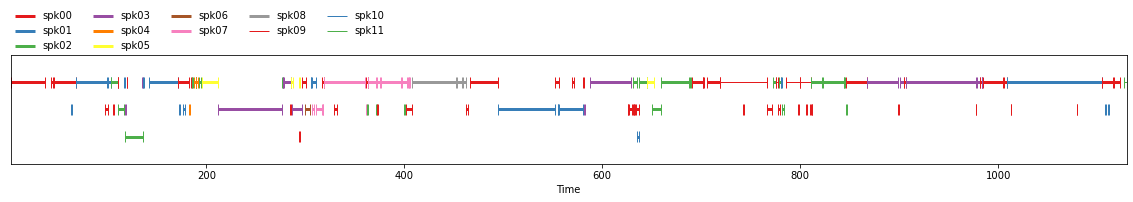

In [10]:
groundtruth # to see the labels of each speaker and time intervals, this will show last one only

SPEAKER zzyyo 1   2.200   34.640 <NA> <NA> speaker_2 <NA> <NA>
SPEAKER zzyyo 1   42.960   1.880 <NA> <NA> speaker_2 <NA> <NA>
SPEAKER zzyyo 1   45.750   21.950 <NA> <NA> speaker_2 <NA> <NA>
SPEAKER zzyyo 1   67.800   31.125 <NA> <NA> speaker_6 <NA> <NA>
SPEAKER zzyyo 1   98.925   1.500 <NA> <NA> speaker_2 <NA> <NA>
SPEAKER zzyyo 1   100.425   2.975 <NA> <NA> speaker_6 <NA> <NA>
SPEAKER zzyyo 1   103.840   13.320 <NA> <NA> speaker_5 <NA> <NA>
SPEAKER zzyyo 1   117.160   1.125 <NA> <NA> speaker_6 <NA> <NA>
SPEAKER zzyyo 1   118.285   18.000 <NA> <NA> speaker_5 <NA> <NA>
SPEAKER zzyyo 1   136.285   0.635 <NA> <NA> speaker_6 <NA> <NA>
SPEAKER zzyyo 1   141.790   29.690 <NA> <NA> speaker_6 <NA> <NA>
SPEAKER zzyyo 1   171.480   11.625 <NA> <NA> speaker_2 <NA> <NA>
SPEAKER zzyyo 1   183.105   0.545 <NA> <NA> speaker_1 <NA> <NA>
SPEAKER zzyyo 1   184.090   1.290 <NA> <NA> speaker_2 <NA> <NA>
SPEAKER zzyyo 1   185.380   1.220 <NA> <NA> speaker_5 <NA> <NA>
SPEAKER zzyyo 1   187.640   1.360 <NA> 

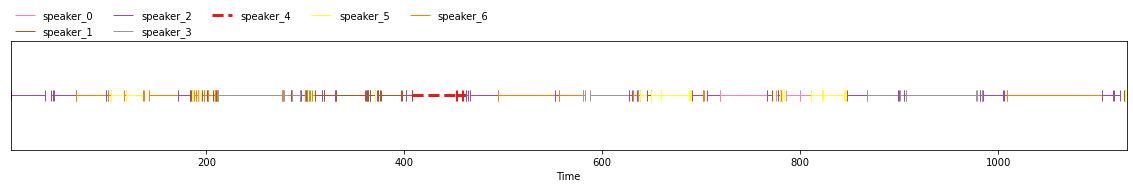

In [11]:
# print generated rttm of last test file
!cat {output_dir}/pred_rttms/zzyyo.rttm

pred_labels = rttm_to_labels(output_dir+'/pred_rttms/zzyyo.rttm')
hypothesis = labels_to_pyannote_object(pred_labels)
hypothesis

In [12]:
# use spyder

hypothesis_rttm_list = []
hypothesis_rttm_filepath= os.path.join(output_dir, 'pred_rttms')

if test_type == 'test':
    hypothesis_rttm_list = glob.glob(hypothesis_rttm_filepath + '/*.rttm', recursive=True)
    
    for ground_rttm, hyp_rttm in zip(groundtruth_rttm_list, hypothesis_rttm_list):
        print("g h", ground_rttm, hyp_rttm)
        !spyder {ground_rttm} {hyp_rttm} --per-file

# der2 = abs(metric)

der = metric(groundtruth, hypothesis)
print(f'diarization error rate = {100 * der:.1f}%')

g h /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/rttms/test/aepyx.rttm /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/pred_rttms/aepyx.rttm
aepyx: DERMetrics(miss=2.29,falarm=0.00,conf=0.07,der=2.35)
Average error rates:
----------------------------------------------------
Missed speaker time = 2.29
False alarm speaker time = 0.00
Speaker error time = 0.07
Diarization error rate (DER) = 2.35
g h /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/rttms/test/aggyz.rttm /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/pred_rttms/aggyz.rttm
aggyz: DERMetrics(miss=0.94,falarm=0.00,conf=6.52,der=7.45)
Average error rates:
----------------------------------------------------
Missed speaker time = 0.94
False alarm speaker time = 0.00
Speaker error time = 6.52
Diarization error rate (DER) = 7.45
g h /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/rttms/test/aiqwk.rttm /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad

crorm: DERMetrics(miss=0.17,falarm=0.00,conf=1.00,der=1.18)
Average error rates:
----------------------------------------------------
Missed speaker time = 0.17
False alarm speaker time = 0.00
Speaker error time = 1.00
Diarization error rate (DER) = 1.18
g h /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/rttms/test/crylr.rttm /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/pred_rttms/crylr.rttm
crylr: DERMetrics(miss=1.48,falarm=0.00,conf=21.10,der=22.57)
Average error rates:
----------------------------------------------------
Missed speaker time = 1.48
False alarm speaker time = 0.00
Speaker error time = 21.10
Diarization error rate (DER) = 22.57
g h /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/rttms/test/cvofp.rttm /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/pred_rttms/cvofp.rttm
cvofp: DERMetrics(miss=0.50,falarm=0.00,conf=0.26,der=0.77)
Average error rates:
----------------------------------------------------
Missed spe

g h /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/rttms/test/eqsta.rttm /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/pred_rttms/eqsta.rttm
eqsta: DERMetrics(miss=12.10,falarm=0.00,conf=11.66,der=23.76)
Average error rates:
----------------------------------------------------
Missed speaker time = 12.10
False alarm speaker time = 0.00
Speaker error time = 11.66
Diarization error rate (DER) = 23.76
g h /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/rttms/test/erslt.rttm /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/pred_rttms/erslt.rttm
erslt: DERMetrics(miss=6.89,falarm=0.00,conf=10.23,der=17.12)
Average error rates:
----------------------------------------------------
Missed speaker time = 6.89
False alarm speaker time = 0.00
Speaker error time = 10.23
Diarization error rate (DER) = 17.12
g h /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/rttms/test/eucfa.rttm /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/

gtjow: DERMetrics(miss=0.22,falarm=0.00,conf=0.16,der=0.38)
Average error rates:
----------------------------------------------------
Missed speaker time = 0.22
False alarm speaker time = 0.00
Speaker error time = 0.16
Diarization error rate (DER) = 0.38
g h /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/rttms/test/gtnjb.rttm /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/pred_rttms/gtnjb.rttm
gtnjb: DERMetrics(miss=1.20,falarm=0.00,conf=5.47,der=6.67)
Average error rates:
----------------------------------------------------
Missed speaker time = 1.20
False alarm speaker time = 0.00
Speaker error time = 5.47
Diarization error rate (DER) = 6.67
g h /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/rttms/test/gukoa.rttm /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/pred_rttms/gukoa.rttm
gukoa: DERMetrics(miss=3.28,falarm=0.00,conf=4.26,der=7.54)
Average error rates:
----------------------------------------------------
Missed speaker

g h /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/rttms/test/isxwc.rttm /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/pred_rttms/isxwc.rttm
isxwc: DERMetrics(miss=2.02,falarm=0.00,conf=21.77,der=23.79)
Average error rates:
----------------------------------------------------
Missed speaker time = 2.02
False alarm speaker time = 0.00
Speaker error time = 21.77
Diarization error rate (DER) = 23.79
g h /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/rttms/test/jbowg.rttm /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/pred_rttms/jbowg.rttm
jbowg: DERMetrics(miss=0.09,falarm=0.00,conf=15.73,der=15.81)
Average error rates:
----------------------------------------------------
Missed speaker time = 0.09
False alarm speaker time = 0.00
Speaker error time = 15.73
Diarization error rate (DER) = 15.81
g h /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/rttms/test/jdrwl.rttm /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/or

kpjud: DERMetrics(miss=7.58,falarm=0.00,conf=6.00,der=13.57)
Average error rates:
----------------------------------------------------
Missed speaker time = 7.58
False alarm speaker time = 0.00
Speaker error time = 6.00
Diarization error rate (DER) = 13.57
g h /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/rttms/test/ktvto.rttm /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/pred_rttms/ktvto.rttm
ktvto: DERMetrics(miss=6.49,falarm=0.00,conf=3.60,der=10.09)
Average error rates:
----------------------------------------------------
Missed speaker time = 6.49
False alarm speaker time = 0.00
Speaker error time = 3.60
Diarization error rate (DER) = 10.09
g h /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/rttms/test/kvkje.rttm /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/pred_rttms/kvkje.rttm
kvkje: DERMetrics(miss=0.03,falarm=0.00,conf=6.02,der=6.05)
Average error rates:
----------------------------------------------------
Missed spe

g h /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/rttms/test/mjmgr.rttm /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/pred_rttms/mjmgr.rttm
mjmgr: DERMetrics(miss=0.97,falarm=0.00,conf=10.57,der=11.54)
Average error rates:
----------------------------------------------------
Missed speaker time = 0.97
False alarm speaker time = 0.00
Speaker error time = 10.57
Diarization error rate (DER) = 11.54
g h /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/rttms/test/mkhie.rttm /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/pred_rttms/mkhie.rttm
mkhie: DERMetrics(miss=0.30,falarm=0.00,conf=10.46,der=10.77)
Average error rates:
----------------------------------------------------
Missed speaker time = 0.30
False alarm speaker time = 0.00
Speaker error time = 10.46
Diarization error rate (DER) = 10.77
g h /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/rttms/test/mqtep.rttm /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/or

optsn: DERMetrics(miss=6.15,falarm=0.00,conf=7.32,der=13.47)
Average error rates:
----------------------------------------------------
Missed speaker time = 6.15
False alarm speaker time = 0.00
Speaker error time = 7.32
Diarization error rate (DER) = 13.47
g h /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/rttms/test/oqwpd.rttm /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/pred_rttms/oqwpd.rttm
oqwpd: DERMetrics(miss=2.40,falarm=0.00,conf=0.29,der=2.69)
Average error rates:
----------------------------------------------------
Missed speaker time = 2.40
False alarm speaker time = 0.00
Speaker error time = 0.29
Diarization error rate (DER) = 2.69
g h /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/rttms/test/otmpf.rttm /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/pred_rttms/otmpf.rttm
otmpf: DERMetrics(miss=0.00,falarm=0.00,conf=2.19,der=2.19)
Average error rates:
----------------------------------------------------
Missed speak

g h /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/rttms/test/qxana.rttm /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/pred_rttms/qxana.rttm
qxana: DERMetrics(miss=0.04,falarm=0.00,conf=4.64,der=4.68)
Average error rates:
----------------------------------------------------
Missed speaker time = 0.04
False alarm speaker time = 0.00
Speaker error time = 4.64
Diarization error rate (DER) = 4.68
g h /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/rttms/test/ralnu.rttm /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/pred_rttms/ralnu.rttm
ralnu: DERMetrics(miss=16.67,falarm=0.00,conf=14.28,der=30.95)
Average error rates:
----------------------------------------------------
Missed speaker time = 16.67
False alarm speaker time = 0.00
Speaker error time = 14.28
Diarization error rate (DER) = 30.95
g h /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/rttms/test/rarij.rttm /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/orac

tkybe: DERMetrics(miss=0.24,falarm=0.00,conf=2.63,der=2.87)
Average error rates:
----------------------------------------------------
Missed speaker time = 0.24
False alarm speaker time = 0.00
Speaker error time = 2.63
Diarization error rate (DER) = 2.87
g h /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/rttms/test/tnjoh.rttm /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/pred_rttms/tnjoh.rttm
tnjoh: DERMetrics(miss=0.70,falarm=0.00,conf=3.28,der=3.98)
Average error rates:
----------------------------------------------------
Missed speaker time = 0.70
False alarm speaker time = 0.00
Speaker error time = 3.28
Diarization error rate (DER) = 3.98
g h /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/rttms/test/tpnyf.rttm /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/pred_rttms/tpnyf.rttm
tpnyf: DERMetrics(miss=0.00,falarm=0.00,conf=13.68,der=13.68)
Average error rates:
----------------------------------------------------
Missed speak

g h /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/rttms/test/vzuru.rttm /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/pred_rttms/vzuru.rttm
vzuru: DERMetrics(miss=0.64,falarm=0.00,conf=29.34,der=29.99)
Average error rates:
----------------------------------------------------
Missed speaker time = 0.64
False alarm speaker time = 0.00
Speaker error time = 29.34
Diarization error rate (DER) = 29.99
g h /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/rttms/test/wcxfk.rttm /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/pred_rttms/wcxfk.rttm
wcxfk: DERMetrics(miss=29.77,falarm=0.00,conf=1.01,der=30.78)
Average error rates:
----------------------------------------------------
Missed speaker time = 29.77
False alarm speaker time = 0.00
Speaker error time = 1.01
Diarization error rate (DER) = 30.78
g h /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/rttms/test/wdvva.rttm /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/or

xvxwv: DERMetrics(miss=1.55,falarm=0.00,conf=0.16,der=1.71)
Average error rates:
----------------------------------------------------
Missed speaker time = 1.55
False alarm speaker time = 0.00
Speaker error time = 0.16
Diarization error rate (DER) = 1.71
g h /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/rttms/test/ybhwz.rttm /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/pred_rttms/ybhwz.rttm
ybhwz: DERMetrics(miss=1.35,falarm=0.00,conf=0.59,der=1.94)
Average error rates:
----------------------------------------------------
Missed speaker time = 1.35
False alarm speaker time = 0.00
Speaker error time = 0.59
Diarization error rate (DER) = 1.94
g h /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/rttms/test/ygrip.rttm /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/voxconverse/oracle_vad/pred_rttms/ygrip.rttm
ygrip: DERMetrics(miss=1.86,falarm=0.00,conf=7.83,der=9.70)
Average error rates:
----------------------------------------------------
Missed speaker

[NeMo W 2022-07-24 16:53:34 nemo_logging:349] /root/anaconda3/lib/python3.9/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
      warnings.warn(
    


diarization error rate = 8.5%


In [ ]:
# using spyder
# diarization error rate = 8.5%

In [ ]:
embeddings['zzyyo'].shape